# Cooking Recipe Analysis with Graph Theory

### Summary

- Used graph theory to analyse how ingredients relate to each other

### Motivation

- There's a lot of recipes and ingredients to know all at once

### Imported Libraries

In [1]:
from src.all_functions import *
from src.communities.communities import *

In [2]:
import _pickle as pickle
#Python Libraries for Mongos Database
import pymongo
from pymongo import MongoClient

In [3]:
from collections import Counter, defaultdict, OrderedDict
import itertools
import operator
from operator import itemgetter

In [4]:
import networkx as nx
import pandas as pd

In [5]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

### Webscraping FlavorDB

In [6]:
import requests
from bs4 import BeautifulSoup
import re

screen shot of flavordb here
https://cosylab.iiitd.edu.in/flavordb/entity_details?id=10


- Some explanation of what Flavor DB is

In [9]:
#Request each ingredient page using pg_num variable
flavor_db_webpage =requests.get('https://cosylab.iiitd.edu.in/flavordb/entity_details?id=10')

#Soup object accesses the HTML of the Request object
soup = BeautifulSoup(flavor_db_webpage.text, 'html.parser')

In [10]:
#Scrape the ingredient name
ingredient_name = str(soup.find('h1', class_='text-primary text-capitalize').text).strip()
print(ingredient_name)

Bantu Beer


In [11]:
#Scrape the category name
category_name = str(soup.find('span', class_='text-capitalize').text).strip()
print(category_name)

Beverage Alcoholic


In [13]:
#Scrape the name of the list of molecules
#Acess the table (https://stackoverflow.com/questions/23377533/python-beautifulsoup-parsing-table)
molecule_table = soup.find('table', id= 'molecules')
table_body = molecule_table.find('tbody')

#initiating a list for each molecule variable    
list_molecule_names = []
list_molecule_id = []
list_molecule_flavor = []

#Access every row in the table 
for row in table_body.find_all('tr'):
    #Access molecule name, id, and flavor in each row
    molecule_name = row.findAll('td')[0].text.strip()
    molecule_id = row.findAll('td')[1].text.strip()
    molecule_flavor = row.findAll('td')[2].text.strip().split(",")
    list_molecule_names.append(molecule_name)
    list_molecule_id.append(molecule_id)
    list_molecule_flavor.append(molecule_flavor)

print(list_molecule_names)

['1-octanol', 'Phenethyl acetate', 'Pentanal', 'Propionaldehyde', '1-Phenyl-1-propanol', '2-Methylbutyl Acetate', 'dimethyl sulfide', 'benzaldehyde', '2-Acetylpyridine', 'Methyl tetradecanoate', '2-Methyl-1-propanol', 'Isobutyl Acetate', 'Oxirane']


# Webscraping Recipe Puppy API

In [14]:
import requests
from bs4 import BeautifulSoup
import re

screen shot of Recipe Puppy API http://www.recipepuppy.com/?i=tuna&q= 

- Another explanation of Recipe Puppy API

In [16]:
url = "http://www.recipepuppy.com/?i=tuna&q="
recipe_puppy_page = requests.get(url)
soup = BeautifulSoup(recipe_puppy_page.text, 'html.parser')

In [19]:
result = soup.find('div', class_ = "result")
result_h3 = result.find('h3')

In [21]:
#name of the result 
result_name = result_h3.text.strip()
print(result_name)

Carpaccio Of Tuna With Seared Tuna Cube And Tuna Tartar Recipe


In [22]:
#link of the result
result_link = re.findall(r'\"(.+?)\"', str(result_h3))[0].strip()
print(result_link)

http://cookeatshare.com/recipes/carpaccio-of-tuna-with-seared-tuna-cube-and-tuna-tartar-100762


In [24]:
#a list of all the ingredients in a recipe
result_ing_list = ["tuna"]
for recipe_ing in result.find('div', class_ = "ings").findAll('a'):
    recipe_ing_name = recipe_ing.text.strip("+").strip()
    result_ing_list.append(recipe_ing_name)
result_ing_list.sort()

print(result_ing_list)

['avocado', 'blood orange', 'chips', 'chives', 'cornmeal', 'cracked black pepper', 'cucumber', 'ginger', 'hot sauce', 'lemon juice', 'mango', 'mint', 'olive oil', 'parsley', 'poppy seeds', 'salt', 'shallot', 'tuna', 'vegetable oil', 'watercress']


# FlavorDB

In [25]:
pickle_in = open("./data/pandas/flavorDB_pandas.pickle","rb")

#Getting the dictionary from the pickle
flavorDB = pickle.load(pickle_in)

- Some ingredients were taken out because they were cooked items


In [26]:
flavorDB.head()

,_id,category,flavor_of_molecules,ingredient,molecule_IDs,molecules,set_molecules,set_molecules_ID,molecule_quantity
0,5ca27b8f13218a1eabac63d6,Animal Product,"[[faint], [very strong, mothball, animal, f...",egg,"[6322, 6736, 31252, 7909, 7284, 7501, 9609, 12...","[L-arginine, 3-Methylindole, 2,5-Dimethylpyraz...","{3-Methylindole, Nonanal, Thiamine Hydrochlori...","{11552, 8094, 1049, 5321950, 27457, 7501, 612,...",55
51,5ca27bd713218a1eabac6409,Cereal,"[[sweet, new mown hay, green, tonka, bitte...",barley,"[323, 7150, 8468, 11509, 637566, 12748, 439341...","[coumarin, Methyl Benzoate, Vanillic acid, 3-H...","{cinnamyl alcohol, Ethyl Vinyl Ketone, Aconiti...","{72276, 309, 5280445, 27457, 61020, 7288, 5365...",141
52,5ca27bd913218a1eabac640a,Cereal,"[[solvent, bread, buttery, sweet, nutty], ...",crispbread,"[18522, 12170, 8858, 5283324, 6202, 798, 8094,...","[2-Methyltetrahydrofuran-3-One, Furfuryl aceta...","{Thiamine Hydrochloride, trans-2-Nonenal, Pyrr...","{8094, 8858, 14514, 240, 7800, 996, 1183, 1130...",23
53,5ca27bda13218a1eabac640b,Cereal,"[[caramellic, spicy], [balsamic, gasoline, ...",malt,"[5367531, 7501, 7284, 6560, 643731, 12748, 926...","[(2E,4E)-Undeca-2,4-dienal, Styrene, 2-Methylb...","{2-Methylthioacetaldehyde, Isoeugenol, 4-Methy...","{5321950, 27457, 11520, 637564, 9261, 7151, 99...",107
54,5ca27bdb13218a1eabac640c,Cereal,"[[fat, herbal, fresh, earthy, woody, mush...",oats,"[20083, 323, 7150, 8468, 7002, 11509, 637566, ...","[Octan-2-ol, coumarin, Methyl Benzoate, Vanill...","{cinnamyl alcohol, Ethyl Vinyl Ketone, STK7377...","{61808, 26447, 309, 5280445, 61020, 7288, 5365...",170


In [27]:
searched_ingredient_list = flavorDB["ingredient"].tolist()
print("Total number of ingredients searched: ", len(searched_ingredient_list))

Total number of ingredients searched:  481


# Recipe Puppy API

In [28]:
pickle_in = open("./data/pandas/mongodb_recipe_puppy_pandas","rb")

#Getting the dictionary from the pickle
recipe_puppy_api = pickle.load(pickle_in)
#Dropping Duplicates
recipe_puppy_api = recipe_puppy_api.drop_duplicates(subset="recipe_name")
#Keeping only recipes that are queried from chosen FlavorDB ingredients
recipe_puppy_api = recipe_puppy_api[recipe_puppy_api["searched_ingredient"].isin(searched_ingredient_list)]

In [29]:
recipe_puppy_api.head()

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
0,5caa762213218a112b0b979f,"[dashi, egg, egg noodles, mushroom, salt, seas...",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg
1,5caa762213218a112b0b97a0,"[egg, water]",http://www.recipezaar.com/Egg-Peeling-for-Egg-...,Egg Peeling for Egg Salad,egg
2,5caa762213218a112b0b97a1,"[black pepper, celery, cucumber, curry powder,...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg
3,5caa762213218a112b0b97a2,"[baking powder, butter, egg, green onion, rame...",http://www.recipezaar.com/Ramen-Noodle-Egg-Foo...,Ramen Noodle Egg Foo Yung,egg
4,5caa762213218a112b0b97a3,"[bacon, black pepper, cheese, egg, salt]",http://www.recipezaar.com/Bacon-and-Egg-Cups-1...,Bacon and Egg Cups,egg


In [30]:
print("number of recipes: ", recipe_puppy_api.shape[0])

number of recipes:  63899


In [31]:
ingredient_list = []
for _, rows in recipe_puppy_api.iterrows():
    for ing in rows["recipe_ingredients"]:
        ingredient_list.append(ing)
print("Number of ingredients in Recipe Puppy API: ", len(ingredient_list))

Number of ingredients in Recipe Puppy API:  469302


In [32]:
print("Number of unique ingredients in Recipe Puppy API: ", len(Counter(ingredient_list)))

Number of unique ingredients in Recipe Puppy API:  1608


# Removing stop ingredients, Data Processing

- Maybe remove this, not too sure
- Like stop word removal in NLP, we will remove "stop ingredients" or ingredients that are too common are removed 

In [33]:
## Temporarily will be removed for now
# stop_ingredients = ['salt', 'sugar', 'pepper', 'white pepper','flour', 'baking powder', 'baking soda', "cornstarch", 'nonstick cooking spray']

In [34]:
# searched_ingredient_list = [x for x in searched_ingredient_list if x not in stop_ingredients]

# Fuzzy Matching, Data Processing


https://github.com/seatgeek/fuzzywuzzy
- Summary of Seatgeek's fuzzy matching

To get a sense of what the fuzzy matched ratios are like

In [38]:
unique_list_of_recipe_puppy_ingredients = list(set(ingredient_list))

In [39]:
standarize_ingredient_dict_rest = {}
for ing in unique_list_of_recipe_puppy_ingredients:
    king_tup = [ing, 0]
    for ing_2 in searched_ingredient_list:
        fuzz_ratio = fuzz.ratio(ing, ing_2)
        if  fuzz_ratio > king_tup[1]:
            king_tup = [ing_2, fuzz_ratio]
        standarize_ingredient_dict_rest[ing] = (king_tup[0], king_tup[1])

In [40]:
standarize_ingredient_dict_rest

{'fruit punch': ('jackfruit', 50),
 'pasilla chili powder': ('cauliflower', 52),
 'coriander': ('coriander', 100),
 'oil': ('dill', 57),
 'rigatoni pasta': ('american shad', 52),
 'marinara sauce': ('soybean sauce', 59),
 'canadian bacon': ('mandarin orange', 55),
 'chocolate pudding': ('chocolate spread', 73),
 'ouzo': ('soursop', 55),
 'cookie': ('creosote', 57),
 'artificial sweetener': ('pacific sardine', 51),
 'bartlett pear': ('bartlett pear', 100),
 'flax seed oil': ('fish oil', 57),
 'liqueur': ('liqourice', 62),
 'garlic salt': ('garlic', 71),
 'tenderloin': ('tangerine', 63),
 'corn': ('acorn', 89),
 'rum extract': ('meat', 53),
 'dried ancho chile': ('red rice', 48),
 'black tea bags': ('black bear', 67),
 'egg noodles': ('woodapple', 50),
 'onion rolls': ('onion', 62),
 'alfredo sauce': ('apple sauce', 75),
 'yellow pepper': ('white pepper', 64),
 'crab meat': ('rainbow smelt', 64),
 'brown raisins': ('raisin', 63),
 'thyme': ('thyme', 100),
 'graham cracker crust': ('garde

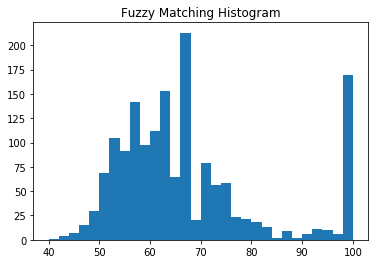

In [41]:
plt.hist([v[1] for k,v in standarize_ingredient_dict_rest.items()], bins=30)
plt.title("Fuzzy Matching Histogram")
plt.show()

- Making a dictionary where keys are the unique ingredients, and the values are the top matched ingredient

In [36]:
standarize_ingredient_dict = {}
for ing in unique_list_of_recipe_puppy_ingredients:
    king_tup = [ing, 0]
    for ing_2 in searched_ingredient_list:
        fuzz_ratio = fuzz.ratio(ing, ing_2)
        if  fuzz_ratio > king_tup[1]:
            king_tup = [ing_2, fuzz_ratio]
    if king_tup[1] >= 85:
        standarize_ingredient_dict[ing] = king_tup[0]

In [37]:
standarize_ingredient_dict

{'coriander': 'coriander',
 'bartlett pear': 'bartlett pear',
 'corn': 'acorn',
 'thyme': 'thyme',
 'asparagus': 'asparagus',
 'wild rice': 'wild rice',
 'raisins': 'raisin',
 'mango': 'mango',
 'winter squash': 'winter squash',
 'honey': 'honey',
 'turnip': 'turnip',
 'carrot': 'carrot',
 'mustard oil': 'mustard oil',
 'peanut': 'peanut',
 'pecan': 'pecans',
 'tomato': 'tomato',
 'basmati rice': 'basmati rice',
 'spearmint': 'spearmint',
 'saffron': 'saffron',
 'yellowfin tuna': 'yellowfin tuna',
 'haddock': 'haddock',
 'garlic': 'garlic',
 'kumquats': 'kumquat',
 'summer savory': 'summer savory',
 'avocados': 'avocado',
 'nutmeg': 'nutmeg',
 'leek': 'leek',
 'tarragon': 'tarragon',
 'anise': 'anise',
 'mint': 'mint',
 'chinese wine': 'chinese quince',
 'lemon balm': 'lemon balm',
 'chayote': 'chayote',
 'pineapple': 'pineapple',
 'winter savory': 'winter savory',
 'pistachios': 'pistachio',
 'endive': 'endive',
 'coconut': 'coconut',
 'quail': 'quail',
 'wheat': 'wheat',
 'papaya': '

In [51]:
sorted_x = sorted(standarize_ingredient_dict.items(), key=operator.itemgetter(1))


In [52]:
sorted_x

[('acorn', 'acorn'),
 ('corn', 'acorn'),
 ('albacore tuna', 'albacore tuna'),
 ('allspice', 'allspice'),
 ('almond', 'almond'),
 ('almonds', 'almond'),
 ('amaranth', 'amaranth'),
 ('anchovy', 'anchovy'),
 ('anise', 'anise'),
 ('apple', 'apple'),
 ('apple cider vinegar', 'apple cider vinegar'),
 ('applesauce', 'apple sauce'),
 ('apricot', 'apricot'),
 ('arrowroot', 'arrowroot'),
 ('asparagus', 'asparagus'),
 ('atlantic salmon', 'atlantic salmon'),
 ('avocados', 'avocado'),
 ('avocado', 'avocado'),
 ('banana', 'banana'),
 ('barley', 'barley'),
 ('bartlett pear', 'bartlett pear'),
 ('basil', 'basil'),
 ('basmati rice', 'basmati rice'),
 ('beef', 'beef'),
 ('beetroot', 'beetroot'),
 ('bitter orange', 'bitter orange'),
 ('black beans', 'black bear'),
 ('black currants', 'black currant'),
 ('brazil nuts', 'brazil nut'),
 ('brazil nut', 'brazil nut'),
 ('broccolini', 'broccoli'),
 ('broccoli', 'broccoli'),
 ('brussels sprout', 'brussels sprout'),
 ('buffalo', 'buffalo'),
 ('bulgur', 'bulgur')

- Replacing all the words with the values in the dictionary, and keeping only recipes that have at least 3 ingredients

In [42]:
def cleaner(row):
    ingredient_list = row["recipe_ingredients"]
    ingredient_list = set([standarize_ingredient_dict[ing] for ing in ingredient_list if ing in standarize_ingredient_dict])
    return ingredient_list

In [43]:
recipe_puppy_api["recipe_ingredients"] = recipe_puppy_api.apply(lambda row: cleaner(row), axis=1)
recipe_puppy_api["num_ingredients"] = recipe_puppy_api.apply(lambda row: len(row["recipe_ingredients"]), axis=1)
recipe_puppy_api = recipe_puppy_api[recipe_puppy_api["num_ingredients"] >= 3]

In [44]:
recipe_puppy_api.head()

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient,num_ingredients
0,5caa762213218a112b0b979f,"{shallot, mushroom, white pepper, egg}",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg,4
2,5caa762213218a112b0b97a1,"{red currant, lemon, walnut, celery, cucumber,...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg,7
11,5caa762213218a112b0b97aa,"{parsley, egg, ham}",http://www.recipezaar.com/Crepes-Complet-Chees...,"Crepes Complet ( Cheese, Ham, and Egg)",egg,3
12,5caa762213218a112b0b97ab,"{celery, egg, ham}",http://www.recipezaar.com/Egg-and-Ham-Salad-42359,Egg and Ham Salad,egg,3
13,5caa762213218a112b0b97ac,"{basil, egg, celery}",http://www.recipezaar.com/Egg-Salad-Longmeadow...,Egg Salad Longmeadow Farm,egg,3


# Quick Analysis of Recipes

- Do a quick Before and after of the number of ingredients and recipes

In [45]:
print("number of recipes: ", recipe_puppy_api.shape[0])

number of recipes:  34734


In [46]:
ingredient_list = []
for _, rows in recipe_puppy_api.iterrows():
    for ing in rows["recipe_ingredients"]:
        ingredient_list.append(ing)
print("Number of ingredients in Recipe Puppy API: ", len(ingredient_list))

Number of ingredients in Recipe Puppy API:  145162


In [47]:
print("Number of unique ingredients in Recipe Puppy API: ", len(Counter(ingredient_list)))

Number of unique ingredients in Recipe Puppy API:  191


In [48]:
ingredient_counter = pd.DataFrame.from_dict(Counter(ingredient_list), orient='index').reset_index()
ingredient_counter = ingredient_counter.rename(columns= {"index": "ingredient", 0: "quantity"})
ingredient_counter = ingredient_counter.set_index('ingredient')
ingredient_counter = ingredient_counter.sort_values(by= ["quantity"], ascending= False)
ingredient_counter["rank"] = np.arange(len(ingredient_counter))

In [50]:
ingredient_counter.head()

,quantity,rank
ingredient,,
garlic,10659,0
onion,9738,1
flour,8145,2
egg,8100,3
parsley,4177,4


In [51]:
ingredient_counter["quantity"].describe()

count      191.000000
mean       760.010471
std       1462.959196
min          1.000000
25%         91.000000
50%        313.000000
75%        726.000000
max      10659.000000
Name: quantity, dtype: float64

- Simple and common ingredients are disproportionally in recipes compared to other ingredients

<function matplotlib.pyplot.show(*args, **kw)>

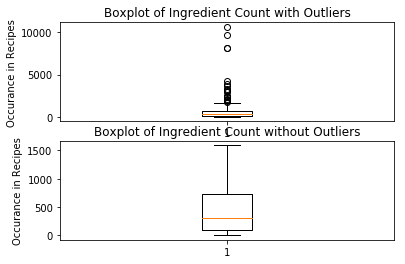

In [52]:
fig, axs = plt.subplots(2)
axs[0].boxplot(ingredient_counter["quantity"])
axs[0].set_title('Boxplot of Ingredient Count with Outliers')
axs[0].set_ylabel("Occurance in Recipes")

axs[1].boxplot(ingredient_counter["quantity"], 0, '')
axs[1].set_title('Boxplot of Ingredient Count without Outliers')
axs[1].set_ylabel("Occurance in Recipes")

plt.show

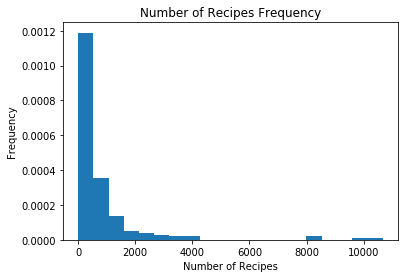

In [53]:
plt.hist(ingredient_counter["quantity"], bins= 20, density=True)
plt.title("Number of Recipes Frequency")
plt.xlabel("Number of Recipes")
plt.ylabel("Frequency")
plt.show()

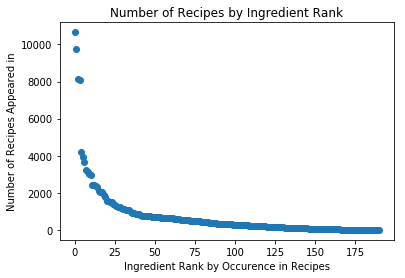

In [54]:
plt.scatter(ingredient_counter["rank"], ingredient_counter["quantity"])
plt.title("Number of Recipes by Ingredient Rank")
plt.xlabel("Ingredient Rank by Occurence in Recipes")
plt.ylabel("Number of Recipes Appeared in")
plt.show()

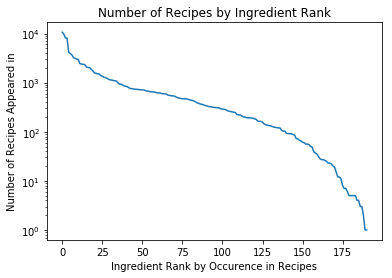

In [55]:
plt.semilogy(ingredient_counter["rank"], ingredient_counter["quantity"])
plt.title("Number of Recipes by Ingredient Rank")
plt.xlabel("Ingredient Rank by Occurence in Recipes")
plt.ylabel("Number of Recipes Appeared in")
plt.show()

/home/ryoiwata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


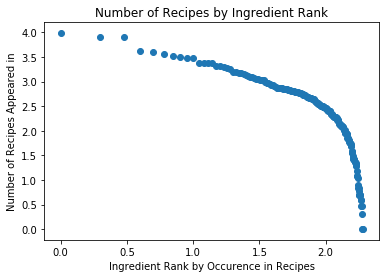

In [56]:
plt.scatter(np.log10(ingredient_counter["rank"]), np.log10(ingredient_counter["quantity"]))
plt.title("Number of Recipes by Ingredient Rank")
plt.xlabel("Ingredient Rank by Occurence in Recipes")
plt.ylabel("Number of Recipes Appeared in")
plt.show()

# Sample Graph

- Explain what graph theory is

In [58]:
sample_recipes = recipe_puppy_api.sample(n=3, random_state=9)

In [59]:
sample_recipes

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient,num_ingredients
101520,5caa818113218a112b0d242f,"{onion, tomato, macaroni}",http://www.recipezaar.com/BBQ-Bacon-Cheeseburg...,BBQ Bacon Cheeseburger Macaroni,macaroni,3
113981,5caa82ed13218a112b0d54dc,"{endive, garlic, ham, chicken}",http://www.bigoven.com/76787-Curly-Endive-and-...,Curly Endive and Bean Soup,endive,4
109821,5caa826f13218a112b0d449c,"{parsley, oregano, garlic}",http://www.cdkitchen.com/recipes/recs/47/Vongo...,Vongole 'Reganate (Baked Clams with Oregano) R...,oregano,3


In [60]:
sample_graph = graph_based_on_shared_recipe_creator(sample_recipes)

- Each ingredient is connected to another ingredient if they share a recipe
- Each cluster represents a recipe

/home/ryoiwata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


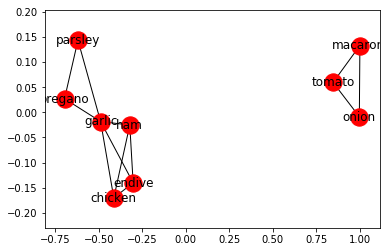

In [61]:
nx.draw_networkx(sample_graph)

### Making a Graph with Entire Recipe Dataset

In [64]:
recipe_graph = graph_based_on_shared_recipe_creator(recipe_puppy_api)

In [62]:
recipe_puppy_api.head()

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient,num_ingredients
0,5caa762213218a112b0b979f,"{shallot, mushroom, white pepper, egg}",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg,4
2,5caa762213218a112b0b97a1,"{red currant, lemon, walnut, celery, cucumber,...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg,7
11,5caa762213218a112b0b97aa,"{parsley, egg, ham}",http://www.recipezaar.com/Crepes-Complet-Chees...,"Crepes Complet ( Cheese, Ham, and Egg)",egg,3
12,5caa762213218a112b0b97ab,"{celery, egg, ham}",http://www.recipezaar.com/Egg-and-Ham-Salad-42359,Egg and Ham Salad,egg,3
13,5caa762213218a112b0b97ac,"{basil, egg, celery}",http://www.recipezaar.com/Egg-Salad-Longmeadow...,Egg Salad Longmeadow Farm,egg,3


## EDA with Graphs

### Measures of Centrality

### Degree Centrality

- Explain what degree centrality is

In [65]:
recipe_degree_centrality = nx.degree_centrality(recipe_graph)

In [66]:
degree_centrality_pd = pd.DataFrame.from_dict(recipe_degree_centrality, orient='index', columns= ["degree_centrality"])
degree_centrality_pd = degree_centrality_pd.sort_values(by= ["degree_centrality"], ascending= False)
degree_centrality_pd["degree_rank"] = np.arange(len(degree_centrality_pd))
degree_centrality_pd.head()

,degree_centrality,degree_rank
garlic,0.984211,0
onion,0.968421,1
flour,0.947368,2
egg,0.942105,3
tomato,0.915789,4


### Betweenness Centrality

- Explain what Betweeness Centrality is

In [67]:
recipe_betweenness_centrality = nx.betweenness_centrality(recipe_graph)

In [68]:
betweenness_centrality_pd = pd.DataFrame.from_dict(recipe_betweenness_centrality, orient='index', columns= ["betweenness_centrality"])
betweenness_centrality_pd = betweenness_centrality_pd.sort_values(by= ["betweenness_centrality"], ascending= False)
betweenness_centrality_pd["betweenness_rank"] = np.arange(len(betweenness_centrality_pd))
betweenness_centrality_pd.head()

,betweenness_centrality,betweenness_rank
garlic,0.027137,0
onion,0.023109,1
flour,0.017001,2
egg,0.016561,3
tomato,0.011913,4


# Eigen Vector Centrality

- Explain what Eigen Vector Centrality is

In [69]:
recipe_eigenvector_centrality = nx.eigenvector_centrality(recipe_graph, max_iter=10000)

In [70]:
eigenvector_centrality_pd = pd.DataFrame.from_dict(recipe_eigenvector_centrality, orient='index', columns= ["eigenvector_centrality"])
eigenvector_centrality_pd = eigenvector_centrality_pd.sort_values(by= ["eigenvector_centrality"], ascending= False)
eigenvector_centrality_pd["eigenvector_rank"] = np.arange(len(eigenvector_centrality_pd))
eigenvector_centrality_pd.head()

,eigenvector_centrality,eigenvector_rank
garlic,0.108012,0
onion,0.107732,1
flour,0.107145,2
egg,0.106897,3
tomato,0.106222,4


# Comparing Centralities

In [63]:
combined_graph = pd.merge(degree_centrality_pd, betweenness_centrality_pd, left_index=True, right_index=True)
combined_graph = pd.merge(combined_graph, eigenvector_centrality_pd, left_index=True, right_index=True)

In [64]:
combined_graph.head(15)

,degree_centrality,degree_rank,betweenness_centrality,betweenness_rank,eigenvector_centrality,eigenvector_rank
garlic,0.983957,0,0.029546,0,0.110182,0
onion,0.967914,1,0.025328,1,0.109888,1
egg,0.925134,2,0.016016,2,0.108552,2
tomato,0.914439,3,0.013393,3,0.108374,3
ginger,0.887701,4,0.011729,4,0.106805,4
carrot,0.887701,5,0.010503,10,0.106670,6
celery,0.882353,6,0.010033,12,0.106751,5
rice,0.882353,7,0.010471,11,0.106280,7
honey,0.877005,8,0.011083,7,0.106059,8
parsley,0.877005,9,0.011452,5,0.106015,9


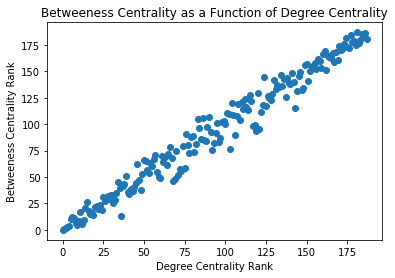

In [65]:
plt.scatter(combined_graph["degree_rank"], combined_graph["betweenness_rank"])
plt.title("Betweeness Centrality as a Function of Degree Centrality")
plt.xlabel("Degree Centrality Rank")
plt.ylabel("Betweeness Centrality Rank")
plt.show()

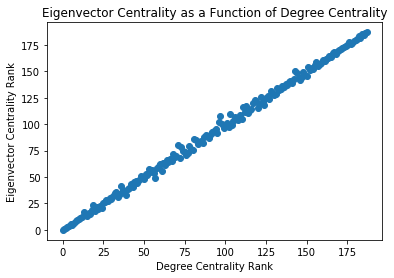

In [66]:
plt.scatter(combined_graph["degree_rank"], combined_graph["eigenvector_rank"])
plt.title("Eigenvector Centrality as a Function of Degree Centrality")
plt.xlabel("Degree Centrality Rank")
plt.ylabel("Eigenvector Centrality Rank")
plt.show()

In [67]:
# plt.scatter(combined_graph["betweenness_rank"], combined_graph["eigenvector_rank"])
# plt.title("Number of Recipes by Ingredient Rank")
# plt.xlabel("Ingredient Rank by Occurence in Recipes")
# plt.ylabel("Number of Recipes Appeared in")
# plt.show()

# Degree Graphs

# Compliments

In [68]:
list_of_edges_quant25 = []
for edge in recipe_graph.edges(data= True):
    ingredient_1 = edge[0]
    ingredient_2 = edge[1]
    quantity_ing1 = recipe_graph.node[ingredient_1]['quantity']
    quantity_ing2 = recipe_graph.node[ingredient_2]['quantity']
    
    if quantity_ing1 >= 25 and quantity_ing2 >= 25:
       list_of_edges_quant25.append(edge)


In [69]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

# Compliments based on Edge Weight

In [70]:
edge_weight_compliment = {}
for a, b, data in sorted(list_of_edges_quant25, key=lambda x: x[2]['weight'], reverse= True):
    edge_weight_compliment[(a,b)] = data["weight"]
#     print('{a} {b} {w}'.format(a=a, b=b, w=data['weight']))

In [71]:
edge_weight_top_compliments = take(15, edge_weight_compliment.items())
edge_weight_top_compliments

[(('onion', 'garlic'), 4018),
 (('parsley', 'garlic'), 1912),
 (('celery', 'onion'), 1843),
 (('tomato', 'garlic'), 1807),
 (('onion', 'tomato'), 1790),
 (('parsley', 'onion'), 1533),
 (('egg', 'cinnamon'), 1503),
 (('onion', 'carrot'), 1456),
 (('garlic', 'chicken'), 1351),
 (('ginger', 'garlic'), 1282),
 (('egg', 'onion'), 1220),
 (('garlic', 'thyme'), 1182),
 (('cumin', 'garlic'), 1155),
 (('onion', 'potato'), 1115),
 (('garlic', 'carrot'), 999)]

# Compliments based on IOU

In [72]:
iou_compliment = {}
for a, b, data in sorted(list_of_edges_quant25, key=lambda x: x[2]['iou'], reverse= True):
    iou_compliment[(a,b)] = data["iou"]

#     print('{a} {b} {w}'.format(a=a, b=b, w=data['iou']))

In [73]:
iou_top_compliments = take(15, iou_compliment.items())
iou_top_compliments

[(('peanut butter', 'peanut oil'), 0.30258620689655175),
 (('onion', 'garlic'), 0.20136313521098526),
 (('nutmeg', 'cinnamon'), 0.17677862044059228),
 (('cocoa powder', 'chocolate spread'), 0.17540322580645162),
 (('celery', 'carrot'), 0.1598279285241562),
 (('egg', 'cinnamon'), 0.15296153063301446),
 (('cumin', 'coriander'), 0.14802631578947367),
 (('celery', 'onion'), 0.14621182070606903),
 (('peanut', 'peanut oil'), 0.14539748953974896),
 (('onion', 'tomato'), 0.13602857359981763),
 (('parsley', 'garlic'), 0.13166230546756644),
 (('tomato', 'garlic'), 0.12820148989003194),
 (('coriander', 'turmeric'), 0.12215758857747223),
 (('cinnamon', 'clove'), 0.11809815950920245),
 (('onion', 'carrot'), 0.11688207433571486)]

# Compliments based on PMI


In [74]:
pmi_compliment = {}
for a, b, data in sorted(list_of_edges_quant25, key=lambda x: x[2]['pmi'], reverse= True):
    if recipe_graph[a][b]["weight"] > 10:
        pmi_compliment[(a,b)] = data["pmi"]
    
    #     print('{a} {b} {w}'.format(a=a, b=b, w=data['pmi']))


In [75]:
pmi_top_compliments = take(10, pmi_compliment.items())
pmi_top_compliments

[(('cocoa powder', 'chocolate spread'), 1.6851147948210432),
 (('peanut butter', 'peanut oil'), 1.5169556471377872),
 (('turmeric', 'fenugreek'), 1.4858498936651359),
 (('turmeric', 'mustard oil'), 1.4337136913365012),
 (('dates', 'brazil nut'), 1.3706133910350273),
 (('horseradish', 'beetroot'), 1.3331266214821071),
 (('peanut', 'peanut oil'), 1.2794735795720502),
 (('wasabi', 'yellowfin tuna'), 1.278000319614625),
 (('chocolate', 'vanilla'), 1.2306304621859059),
 (('cardamom', 'pistachio'), 1.1839716009203065)]

# Substitutes

In [76]:
def bhattacharyya_quotient(ingredient_1 = "egg", x = "flour"):
    
    if recipe_graph.get_edge_data(ingredient_1, x) == None:
        ing_1_quotient = 0
    
    else:
        ing_1_numerator = recipe_graph.get_edge_data(ingredient_1, x)["weight"]
        ing_1_denominator = sum([data["weight"] for _, __, data in recipe_graph.edges(ingredient_1, data = True)])
        ing_1_quotient = ing_1_numerator / ing_1_denominator 
    
    return ing_1_quotient

In [77]:
def bhattacharyya_distance(ingredient_1 = "pecans", ingredient_2 = "walnut", graph= recipe_graph):
    result = 0 
    for iter_ing in graph.nodes():
        quot_1 = bhattacharyya_quotient(ingredient_1, iter_ing)
        quot_2 = bhattacharyya_quotient(ingredient_2, iter_ing)
        result += (quot_1 * quot_2) ** 0.5
    
    if result == 0:
        return 1
    return -1 * np.log10(result)

In [78]:
bhattacharyya_distance()

0.021726652170343065

# Bhattacharyya Distance on every possible combination

In [80]:
dict_bhattacharry_distance = {}
for combo in combinations(recipe_graph.nodes(), 2):
#     if recipe_graph.nodes[combo[0]]['quantity'] < 2000 or recipe_graph.nodes[combo[1]]['quantity'] < 2000:
#         continue
    bd = bhattacharyya_distance(combo[0], combo[1])
    dict_bhattacharry_distance[combo] = bd


In [84]:
bhattacharry_distance_df = pd.DataFrame.from_dict(dict_bhattacharry_distance, orient='index', columns=["bhattacharry_distance"])
bhattacharry_distance_df = bhattacharry_distance_df.sort_values(by= ["bhattacharry_distance"], ascending = True)
bhattacharry_distance_df.head(15)

,bhattacharry_distance
"(walnut, pecans)",0.021727
"(winter squash, butternut squash)",0.026077
"(shallot, lemon)",0.026897
"(walnut, almond)",0.027765
"(walnut, nuts)",0.028922
"(orange, honey)",0.029923
"(shallot, chive)",0.029952
"(parsley, spinach)",0.030120
"(parsley, thyme)",0.030531
"(parsley, basil)",0.030540


In [81]:
sorted_bhattacharry_distance = sorted(dict_bhattacharry_distance.items(), key=lambda kv: kv[1])
sorted_dict_bhattacharry_distance = OrderedDict(sorted_bhattacharry_distance)
bhattacharyya_top_substitues = take(50, sorted_dict_bhattacharry_distance.items())
bhattacharyya_top_substitues

[(('walnut', 'pecans'), 0.021726652170343065),
 (('winter squash', 'butternut squash'), 0.02607667262830606),
 (('shallot', 'lemon'), 0.02689715209939535),
 (('walnut', 'almond'), 0.027764802320106387),
 (('walnut', 'nuts'), 0.02892178126668324),
 (('orange', 'honey'), 0.029923003671596535),
 (('shallot', 'chive'), 0.029952424618384432),
 (('parsley', 'spinach'), 0.03011983462245488),
 (('parsley', 'thyme'), 0.030531233032937078),
 (('parsley', 'basil'), 0.03054004552664331),
 (('chicken', 'turkey'), 0.031013950615920213),
 (('sage', 'marjoram'), 0.031107012052149167),
 (('quinoa', 'bulgur'), 0.031176796146054835),
 (('clove', 'allspice'), 0.03210111900131082),
 (('chicken', 'pork'), 0.032396086470708095),
 (('mushroom', 'celery'), 0.032830782353192034),
 (('chicken', 'tofu'), 0.033094506563657484),
 (('butternut', 'butternut squash'), 0.033137913373720164),
 (('rice', 'spinach'), 0.03341461221782918),
 (('thyme', 'rosemary'), 0.03419888487750945),
 (('pear', 'plum'), 0.034216897246361

# Interpretation Based on Molecules

- Explain what flavor molecules are

In [85]:
flavorDB["category"].unique()

array(['Animal Product', 'Cereal', 'Fish', 'Fruit', 'Fruit Citrus',
       'Fruit Essence', 'Fungus', 'Herb', 'Meat', 'Nut',
       'Plant Derivative', 'Spice', 'Vegetable', 'Cabbage',
       'Vegetable Root', 'Vegetable Fruit', 'Gourd', 'Vegetable Stem',
       'Vegetable Tuber'], dtype=object)

In [86]:
flavorDB["category"].value_counts()

Fish                120
Fruit                82
Herb                 51
Meat                 46
Spice                25
Vegetable            24
Cereal               23
Nut                  21
Plant Derivative     20
Cabbage              16
Fungus               11
Vegetable Tuber      10
Fruit Citrus         10
Vegetable Root        8
Gourd                 7
Vegetable Fruit       4
Fruit Essence         1
Animal Product        1
Vegetable Stem        1
Name: category, dtype: int64

In [87]:
flavorDB.head()

,_id,category,flavor_of_molecules,ingredient,molecule_IDs,molecules,set_molecules,set_molecules_ID,molecule_quantity
0,5ca27b8f13218a1eabac63d6,Animal Product,"[[faint], [very strong, mothball, animal, f...",egg,"[6322, 6736, 31252, 7909, 7284, 7501, 9609, 12...","[L-arginine, 3-Methylindole, 2,5-Dimethylpyraz...","{2-Methylbutyraldehyde, Nonanal, Octanal, Dl-P...","{8027, 18827, 12748, 379, 994, 402, 12020, 196...",55
51,5ca27bd713218a1eabac6409,Cereal,"[[sweet, new mown hay, green, tonka, bitte...",barley,"[323, 7150, 8468, 11509, 637566, 12748, 439341...","[coumarin, Methyl Benzoate, Vanillic acid, 3-H...","{Thiazole, indole-3-acetic acid, Dl-Phenylalan...","{12748, 637511, 89594, 880, 5280445, 1049, 180...",141
52,5ca27bd913218a1eabac640a,Cereal,"[[solvent, bread, buttery, sweet, nutty], ...",crispbread,"[18522, 12170, 8858, 5283324, 6202, 798, 8094,...","[2-Methyltetrahydrofuran-3-One, Furfuryl aceta...","{Heptanoic Acid, 1-Penten-3-Ol, thiamine, 2-Ac...","{14514, 8027, 8858, 12170, 12020, 247, 7800, 1...",23
53,5ca27bda13218a1eabac640b,Cereal,"[[caramellic, spicy], [balsamic, gasoline, ...",malt,"[5367531, 7501, 7284, 6560, 643731, 12748, 926...","[(2E,4E)-Undeca-2,4-dienal, Styrene, 2-Methylb...","{Thiazole, lauric acid, 2-Heptanone, 1-Nonanol...","{18698, 12748, 8914, 19602, 12266, 7501, 1049,...",107
54,5ca27bdb13218a1eabac640c,Cereal,"[[fat, herbal, fresh, earthy, woody, mush...",oats,"[20083, 323, 7150, 8468, 7002, 11509, 637566, ...","[Octan-2-ol, coumarin, Methyl Benzoate, Vanill...","{Thiazole, 2-Heptanone, indole-3-acetic acid, ...","{17000, 12170, 8914, 637511, 31253, 19602, 528...",170


In [88]:
within_category_ratio_dict = {}
for category in flavorDB["category"].unique():
    print(category)
    category_ratio = np.array([])
    category_flavorDB = flavorDB[flavorDB["category"] == category]
    if len(category_flavorDB) < 5:
        continue
    category_ing_list = category_flavorDB["ingredient"].tolist()
    for combo in combinations(category_ing_list, 2):
        ratio, _, __, ___ = common_pair_analysis(combo[0], combo[1])
        category_ratio = np.append(category_ratio, ratio)
    avg_category_ratio = np.mean(category_ratio)
    within_category_ratio_dict[category] = avg_category_ratio   

Animal Product
Cereal
Fish


KeyboardInterrupt: 

In [ ]:
within_category_ratio_dict

In [ ]:
with open('./data/within_category_ratio_arr', 'wb') as file:
    file.write(pickle.dumps(within_category_ratio_arr))
    file.close()

In [ ]:
within_category_ratio_arr = np.array(list(within_category_ratio_dict.values()))

In [92]:
within_category_ratio_dict = {'Beverage Caffeinated': 0.023188029601838158, 'Cereal': 0.47193357224355886, 'Maize': 0.08685947094578159, 'Dairy': 0.2705332213408974, 'Berry': 0.6709720505399656, 'Seafood': 0.1805610937894723, 'Fish': 0.4755572893609933, 'Fruit': 0.3623062597191793, 'Fruit Citrus': 0.22556767676992678, 'Fungus': 0.5675762075179079, 'Herb': 0.5729498524273214, 'Meat': 0.36729174033525025, 'Nut': 0.6560600269937148, 'Plant Derivative': 0.07119239491088235, 'Spice': 0.33893145620402493, 'Vegetable': 0.5669787790025552, 'Cabbage': 0.7815459100999627, 'Vegetable Root': 0.7054557583136626, 'Gourd': 0.8039874482326979, 'Vegetable Tuber': 0.6727014995708049}

In [93]:
within_category_ratio_arr = np.array(list(within_category_ratio_dict.values()))

{'Beverage Caffeinated': 0.023188029601838158,
 'Cereal': 0.47193357224355886,
 'Maize': 0.08685947094578159,
 'Dairy': 0.2705332213408974,
 'Berry': 0.6709720505399656,
 'Seafood': 0.1805610937894723,
 'Fish': 0.4755572893609933,
 'Fruit': 0.3623062597191793,
 'Fruit Citrus': 0.22556767676992678,
 'Fungus': 0.5675762075179079,
 'Herb': 0.5729498524273214,
 'Meat': 0.36729174033525025,
 'Nut': 0.6560600269937148,
 'Plant Derivative': 0.07119239491088235,
 'Spice': 0.33893145620402493,
 'Vegetable': 0.5669787790025552,
 'Cabbage': 0.7815459100999627,
 'Vegetable Root': 0.7054557583136626,
 'Gourd': 0.8039874482326979,
 'Vegetable Tuber': 0.6727014995708049}

# Molecule Ratio of Top Bhattacharyya Distances

In [89]:
ratio_bhattacharyya_arr = np.array([])
for pair in bhattacharyya_top_substitues:
    ing1 = pair[0][0]
    ing2 = pair[0][1]
    ratio, _, __, ___ = common_pair_analysis(ing1, ing2)
    ratio_bhattacharyya_arr = np.append(ratio_bhattacharyya_arr, ratio)
    print(ratio, ing1, ing2)


0.6453488372093024 walnut pecans
1.0 winter squash butternut squash
0.45410628019323673 shallot lemon
0.6459627329192547 walnut almond
0.014285714285714285 walnut nuts
0.10108303249097472 orange honey
0.8 shallot chive
0.47572815533980584 parsley spinach
0.5291479820627802 parsley thyme
0.49206349206349204 parsley basil
0.1044776119402985 chicken turkey
0.6650246305418719 sage marjoram
0.031914893617021274 quinoa bulgur
0.5381165919282511 clove allspice
0.3150684931506849 chicken pork
0.3413897280966767 mushroom celery
0.037037037037037035 chicken tofu
1.0 butternut butternut squash
0.4801762114537445 rice spinach
0.5767634854771784 thyme rosemary
0.5363636363636364 pear plum
0.4434389140271493 lemon chive
0.37800687285223367 mushroom thyme
0.33993399339933994 mushroom marjoram
0.5737704918032787 shallot onion
0.6434426229508197 basil oregano
0.5349794238683128 parsley rosemary
0.5748502994011976 chive spinach
0.42857142857142855 lemon spinach
0.34838709677419355 mushroom carrot
0.5285

In [90]:
ratio_bhattacharyya_arr

array([0.64534884, 1.        , 0.45410628, 0.64596273, 0.01428571,
       0.10108303, 0.8       , 0.47572816, 0.52914798, 0.49206349,
       0.10447761, 0.66502463, 0.03191489, 0.53811659, 0.31506849,
       0.34138973, 0.03703704, 1.        , 0.48017621, 0.57676349,
       0.53636364, 0.44343891, 0.37800687, 0.33993399, 0.57377049,
       0.64344262, 0.53497942, 0.5748503 , 0.42857143, 0.3483871 ,
       0.52851711, 0.61926606, 0.33333333, 0.50769231, 0.41832669,
       0.53815261, 0.68208092, 0.41818182, 0.45757576, 0.58208955,
       0.11210762, 0.32522796, 0.6097561 , 0.35603715, 0.42136499,
       0.4122449 , 0.61650485, 0.34931507, 0.52840909, 0.5026455 ])

Combinging the Two

In [95]:
from scipy import stats

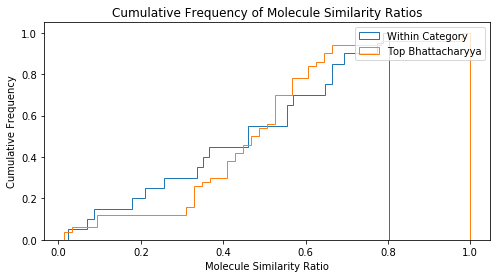

In [107]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(within_category_ratio_arr, 50, density=True, histtype='step',cumulative=True, label='Within Category')
ax.hist(ratio_bhattacharyya_arr, 50, density=True, histtype='step',cumulative=True, label='Top Bhattacharyya')
plt.legend()
plt.title("Cumulative Frequency of Molecule Similarity Ratios")
plt.xlabel("Molecule Similarity Ratio")
plt.ylabel("Cumulative Frequency")
plt.show()


In [108]:
stats.ks_2samp(ratio_bhattacharyya_arr, within_category_ratio_arr)

Ks_2sampResult(statistic=0.20000000000000007, pvalue=0.5674924919696369)

In [109]:
len(within_category_ratio_arr)

20

In [ ]:
stats.ks_2samp(ratio_bhattacharyya_arr, within_category_ratio_arr)

In [110]:
len(ratio_bhattacharyya_arr)

50

# All of Bhattacharyya Distances

[(('walnut', 'pecans'), 0.015992631027561786),
 (('milk', 'skimmed milk'), 0.01969130052850979),
 (('cheese', 'cheddar cheese'), 0.020758856383458413),
 (('white pepper', 'chive'), 0.022141242304505232),
 (('walnut', 'almond'), 0.025280848456086302),
 (('parmesan cheese', 'romano cheese'), 0.02654215229680028),
 (('white pepper', 'parsley'), 0.026740686950173915),
 (('white pepper', 'potato'), 0.02743646945584778),
 (('milk', 'evaporated milk'), 0.02788176595653082),
 (('white pepper', 'leek'), 0.02823937284073544),
 (('shallot', 'lemon'), 0.028336436142838588),
 (('chicken', 'turkey'), 0.028716291184999895),
 (('cheese', 'swiss cheese'), 0.028874325568267512),
 (('parsley', 'thyme'), 0.028994108654302433),
 (('winter squash', 'butternut squash'), 0.029137430905819255),
 (('shallot', 'chive'), 0.029637308496894013),
 (('white pepper', 'thyme'), 0.029751848864108747),
 (('mushroom', 'thyme'), 0.029791831961968565),
 (('mushroom', 'parsley'), 0.030373500165506127),
 (('clove', 'allspice'), 0.03042292262524438),
 (('white pepper', 'mushroom'), 0.030581148713462042),
 (('pecans', 'almond'), 0.03061444424266615),
 (('white pepper', 'tarragon'), 0.03092448013271665),
 (('cheese', 'parmesan cheese'), 0.03097950054800081),
 (('sweet potato', 'yam'), 0.031083459937286693),
 (('chicken', 'shrimp'), 0.03163944828548799),
 (('plum', 'apricot'), 0.03191610601043731),
 (('thyme', 'rosemary'), 0.03192963348900025),
 (('rosemary', 'marjoram'), 0.032015391231895396),
 (('honey', 'orange'), 0.03242587283732452),
 (('tomato', 'cherry tomato'), 0.03251036216192002),
 (('milk', 'buttermilk'), 0.032581199941510715),
 (('mushroom', 'celery'), 0.03260822322134255),
 (('thyme', 'marjoram'), 0.03267972185722435),
 (('blackberry', 'raspberry'), 0.03268375657039242),
 (('mushroom', 'marjoram'), 0.03276794109350866),
 (('white pepper', 'shallot'), 0.03281002486134788),
 (('parsley', 'spinach'), 0.03283424944542265),
 (('sage', 'marjoram'), 0.03288480236668147),
 (('cheddar cheese', 'swiss cheese'), 0.032936839941316534),
 (('white pepper', 'pepper'), 0.03295336297563834),
 (('chive', 'asparagus'), 0.03325625315298724),
 (('potato', 'thyme'), 0.033400773432801956),
 (('blue cheese', 'roquefort cheese'), 0.033459643372212744),
 (('mushroom', 'potato'), 0.03349218963433239),
 (('sweet potato', 'butternut squash'), 0.03350297008384161),
 (('plum', 'prickly pear'), 0.03378351962440435),
 (('parsley', 'rosemary'), 0.03378645124424151),
 (('chive', 'parsley'), 0.03383918843398103),
 (('fish', 'lobster'), 0.033897448999353576),
 (('thyme', 'sage'), 0.03400490686563681),
 (('nuts', 'pecans'), 0.03413923134160778),
 (('shallot', 'onion'), 0.03418304412425414),
 (('bartlett pear', 'prickly pear'), 0.03442343692769297),
 (('tarragon', 'thyme'), 0.03473301688667244),
 (('white pepper', 'carrot'), 0.034771981589772696),
 (('chive', 'leek'), 0.03497325857174126),
 (('chive', 'thyme'), 0.035257795536759964),
 (('peach', 'apricot'), 0.035324863062122944),
 (('tarragon', 'fennel'), 0.03537662711802633),
 (('white pepper', 'lemon'), 0.03541562538786783),
 (('basil', 'spinach'), 0.03556194369500145),
 (('parsley', 'marjoram'), 0.035741058390228266),
 (('basil', 'parsley'), 0.03578441613970702),
 (('parsley', 'potato'), 0.03579106315258766),
 (('thyme', 'leek'), 0.03584879821535855),
 (('white pepper', 'cream'), 0.03590153176071061),
 (('white pepper', 'cheese'), 0.03590273051564559),
 (('romano cheese', 'provolone cheese'), 0.0360192006809886),
 (('broccoli', 'spinach'), 0.036096416303985725),
 (('parsnip', 'leek'), 0.03614332173152845),
 (('chive', 'tarragon'), 0.03623835020940512),
 (('parsley', 'leek'), 0.03632654975048029),
 (('basil', 'oregano'), 0.03633453501431125),
 (('currant', 'raisin'), 0.03647031483899562),
 (('shallot', 'parsley'), 0.03648596893049667),
 (('potato', 'leek'), 0.036496273753929574),
 (('spinach', 'asparagus'), 0.03657478175796906),
 (('celery', 'thyme'), 0.03658782392409654),
 (('white pepper', 'asparagus'), 0.03661312805879911),
 (('chicken', 'pork'), 0.03670233327672222),
 (('shallot', 'leek'), 0.03678736441401048),
 (('mushroom', 'carrot'), 0.03686294062840946),
 (('tarragon', 'leek'), 0.03696652586156405),
 (('parsley', 'asparagus'), 0.037042540217930436),
 (('parsley', 'pepper'), 0.03723457036932611),
 (('mozzarella cheese', 'provolone cheese'), 0.0374977488695388),
 (('chive', 'spinach'), 0.03767345345352922),
 (('oregano', 'cherry tomato'), 0.03767585812174505),
 (('carrot', 'thyme'), 0.0377847459793727),
 (('sage', 'rosemary'), 0.03788983976319628),
 (('lemon', 'chive'), 0.03815475916974138),
 (('tarragon', 'rosemary'), 0.03827653898508433),
 (('parsley', 'tomato'), 0.0383236953768516),
 (('white pepper', 'sage'), 0.03832867616246678),
 (('leek', 'rosemary'), 0.0383717754737211),
 (('white pepper', 'chicken'), 0.03837313113620204),
 (('sweet potato', 'winter squash'), 0.03846176011168271),
 (('tomato', 'oregano'), 0.03851897587929799),
 (('mushroom', 'broccoli'), 0.038585351767203936),
 (('beef', 'turkey'), 0.038695559748002935),
 (('white pepper', 'spinach'), 0.03871671541116329),
 (('fish', 'shrimp'), 0.03872771952098796),
 (('nutmeg', 'pecans'), 0.038789597515901005),
 (('fish', 'squid'), 0.03883531160311627),
 (('walnut', 'nutmeg'), 0.038838679866724395),
 (('shallot', 'fennel'), 0.03893023347431445),
 (('white pepper', 'celery'), 0.03896500563977031),
 (('parsley', 'green beans'), 0.03904175031053488),
 (('shallot', 'thyme'), 0.039193824722166704),
 (('bulgur', 'quinoa'), 0.039273905388107745),
 (('orange', 'yogurt'), 0.039294663159715235),
 (('lobster', 'haddock'), 0.039335561719204735),
 (('pecans', 'apple'), 0.03944915132504325),
 (('milk', 'cream'), 0.03948876212581419),
 (('coriander', 'turmeric'), 0.03958552252809674),
 (('mozzarella cheese', 'romano cheese'), 0.039653345740549226),
 (('white pepper', 'onion'), 0.03969772595475256),
 (('salmon', 'atlantic salmon'), 0.03971962603331425),
 (('parsley', 'tarragon'), 0.03976256220546426),
 (('mushroom', 'asparagus'), 0.03979057254119462),
 (('pepper', 'cherry tomato'), 0.03979149981890923),
 (('mango', 'papaya'), 0.03984120712798399),
 (('shallot', 'rosemary'), 0.03988236922236324),
 (('evaporated milk', 'skimmed milk'), 0.039926359967166654),
 (('apricot', 'prickly pear'), 0.03993807970514704),
 (('raisin', 'dates'), 0.03993997522131402),
 (('mushroom', 'pepper'), 0.039946479425194685),
 (('chicken', 'beef'), 0.04009938584296138),
 (('chive', 'potato'), 0.04013852841783802),
 (('mushroom', 'sage'), 0.04016930331982235),
 (('rabbit', 'pheasant'), 0.04017793968471474),
 (('celery', 'parsley'), 0.04019442733414342),
 (('leek', 'marjoram'), 0.04035991147355691),
 (('mandarin orange', 'apricot'), 0.04037925309592704),
 (('mushroom', 'oyster mushroom'), 0.040440788352374),
 (('cheese', 'chive'), 0.040447621958108304),
 (('shallot', 'tarragon'), 0.04046359910940429),
 (('mushroom', 'basil'), 0.040476332065829006),
 (('white pepper', 'fennel'), 0.04051627628069528),
 (('lemon', 'pepper'), 0.0406548213494479),
 (('shallot', 'asparagus'), 0.040664928014476284),
 (('tomato', 'pepper'), 0.04068757180772259),
 (('white pepper', 'rosemary'), 0.04069422673622769),
 (('cheese', 'mustard'), 0.04079404576018203),
 (('parsley', 'carrot'), 0.040904194918535995),
 (('apple', 'allspice'), 0.04099538041207114),
 (('mushroom', 'leek'), 0.041019730940153966),
 (('tarragon', 'asparagus'), 0.041042572475887766),
 (('pepper', 'thyme'), 0.041117826318439125),
 (('walnut', 'nuts'), 0.041130894625966676),
 (('white pepper', 'mustard'), 0.0411512627542403),
 (('thyme', 'green beans'), 0.04117281242293932),
 (('mushroom', 'tarragon'), 0.0412493403613208),
 (('mushroom', 'rosemary'), 0.04137614957713647),
 (('mushroom', 'chive'), 0.04144370646619236),
 (('lemon', 'rice'), 0.04145242173228602),
 (('oregano', 'pepper'), 0.0414876419725677),
 (('white pepper', 'shrimp'), 0.041490687430805875),
 (('buttermilk', 'skimmed milk'), 0.04150681393289487),
 (('swiss cheese', 'gruyere cheese'), 0.04152307774893712),
 (('onion', 'parsley'), 0.04152954111159216),
 (('sage', 'leek'), 0.041625322477239914),
 (('raisin', 'allspice'), 0.04163055421872852),
 (('apple', 'raisin'), 0.041637820909739456),
 (('raisin', 'apricot'), 0.04164201439734417),
 (('parsley', 'oregano'), 0.041659018741676476),
 (('nutmeg', 'apple'), 0.041673566422291475),
 (('walnut', 'apple'), 0.04167972990632462),
 (('honey', 'yogurt'), 0.041756308988272435),
 (('parsley', 'chicken'), 0.041775491517573364),
 (('chicken', 'pepper'), 0.041918330263774006),
 (('raisin', 'plum'), 0.04199555202925451),
 (('raspberry', 'strawberry'), 0.042098670281091474),
 (('cream cheese', 'cottage cheese'), 0.042202513982612724),
 (('honey', 'almond'), 0.04222168168856651),
 (('rice', 'yogurt'), 0.04228859178781141),
 (('spinach', 'pepper'), 0.0423440367141966),
 (('almond', 'raisin'), 0.04243422092543581),
 (('lemon', 'parsley'), 0.04243735583319378),
 (('shrimp', 'pepper'), 0.04245988980299089),
 (('oregano', 'eggplant'), 0.0424630454939256),
 (('mushroom', 'green beans'), 0.042563021992754045),
 (('mushroom', 'tomato'), 0.04261101583776059),
 (('dates', 'apricot'), 0.04266919922460945),
 (('pecans', 'raisin'), 0.0426712875952765),
 (('mint', 'yogurt'), 0.04268265456335722),
 (('squid', 'monkfish'), 0.04268510544228308),
 (('apple', 'sweet potato'), 0.04270269920286144),
 (('chicken', 'carrot'), 0.042728502255499734),
 (('lemon', 'fennel'), 0.042790741743521064),
 (('carrot', 'pork'), 0.0428335173005841),
 (('nutmeg', 'raisin'), 0.04284271980674664),
 (('lemon', 'thyme'), 0.04300844867374516),
 (('peach', 'plum'), 0.043022588649319946),
 (('pepper', 'rosemary'), 0.043054255609388976),
 (('allspice', 'sweet potato'), 0.04308421761726594),
 (('cheese', 'cottage cheese'), 0.04309443791783608),
 (('basil', 'pepper'), 0.043108478873572435),
 (('mustard', 'potato'), 0.04313829451438538),
 (('kale', 'thyme'), 0.04313855791818169),
 (('potato', 'sage'), 0.04314565838122621),
 (('vinegar', 'carrot'), 0.0431596801927332),
 (('lemon', 'tarragon'), 0.04319689812402595),
 (('chive', 'pepper'), 0.04321766445224145),
 (('potato', 'pepper'), 0.04326101069808967),
 (('peach', 'prickly pear'), 0.043263978354561264),
 (('potato', 'marjoram'), 0.04329647340752291),
 (('apple', 'clove'), 0.04333654659640849),
 (('chicken', 'green beans'), 0.043390968798891004),
 (('chervil', 'fennel'), 0.04342489065457709),
 (('walnut', 'hazelnut'), 0.04351757958193494),
 (('pepper', 'green beans'), 0.043626790535608834),
 (('honey', 'apple'), 0.04368414755614115),
 (('apple', 'almond'), 0.04371476351532007),
 (('nutmeg', 'sweet potato'), 0.04373690856246772),
 (('cream', 'almond'), 0.04376979635580359),
 (('chive', 'cream'), 0.04383706494844081),
 (('fish', 'monkfish'), 0.043853870538552504),
 (('onion', 'leek'), 0.04386962879861383),
 (('asparagus', 'green beans'), 0.04388126844017345),
 (('white pepper', 'lobster'), 0.043896942561584176),
 (('cumin', 'coriander'), 0.04393327978376686),
 (('turnip', 'parsnip'), 0.0440832596446764),
 (('ginger', 'clove'), 0.04411526249752091),
 (('white pepper', 'parmesan cheese'), 0.04413526066745514),
 (('ham', 'turkey'), 0.04417795998195534),
 (('carrot', 'sage'), 0.044191999454110696),
 (('pork', 'turkey'), 0.04419881513339144),
 (('vinegar', 'yogurt'), 0.044265094709584764),
 (('coconut', 'apricot'), 0.04428467624016179),
 (('white pepper', 'marjoram'), 0.04441745756971784),
 (('white pepper', 'tomato'), 0.04443216008394792),
 (('onion', 'thyme'), 0.04447100036559472),
 (('cheese', 'spinach'), 0.04451041611398945),
 (('milk', 'nutmeg'), 0.04456290623479201),
 (('thyme', 'fennel'), 0.04462419853423194),
 (('cocoa powder', 'chocolate'), 0.0446261659993597),
 (('nutmeg', 'almond'), 0.04465316937761302),
 (('tarragon', 'chervil'), 0.0447138914364187),
 (('mushroom', 'chicken'), 0.04472766953882734),
 (('kale', 'parsnip'), 0.044774703795282485),
 (('parsley', 'sage'), 0.0447934420694616),
 (('oregano', 'marjoram'), 0.04481371765163155),
 (('potato', 'carrot'), 0.04482502721753879),
 (('raisin', 'clove'), 0.04492106391542502),
 (('clove', 'sweet potato'), 0.044991852405874104),
 (('celery', 'green beans'), 0.04501146885430622),
 (('mushroom', 'oregano'), 0.045018672871302304),
 (('lemon', 'carrot'), 0.04511442227682895),
 (('lemon', 'vinegar'), 0.045121202795320406),
 (('milk', 'almond'), 0.045192479982899936),
 (('apricot', 'cherry'), 0.045195416846230865),
 (('chive', 'chicken'), 0.04519912571599833),
 (('orange', 'almond'), 0.045264145306882234),
 (('mushroom', 'parmesan cheese'), 0.045305197171589214),
 (('cheese', 'gruyere cheese'), 0.04535530653436283),
 (('chive', 'mustard'), 0.04546121195234323),
 (('rosemary', 'green beans'), 0.045468983386369274),
 (('pork', 'beef'), 0.045471263518228784),
 (('flour', 'cream'), 0.04550064398299173),
 (('parsley', 'broccoli'), 0.045505230846117614),
 (('milk', 'cream cheese'), 0.045528570398069845),
 (('nutmeg', 'evaporated milk'), 0.0455614769068368),
 (('mushroom', 'spinach'), 0.045586095162153326),
 (('spinach', 'oregano'), 0.04559263718033428),
 (('cheese', 'parsley'), 0.04559596110735646),
 (('leek', 'fennel'), 0.04561360072677074),
 (('chicken', 'spinach'), 0.045697029511147534),
 (('gruyere cheese', 'oyster mushroom'), 0.045708868001933384),
 (('basil', 'eggplant'), 0.04574514855571609),
 (('basil', 'thyme'), 0.045830038732808),
 (('beef', 'kale'), 0.04584470116366522),
 (('lemon', 'yogurt'), 0.04585266965098683),
 (('cheese', 'romano cheese'), 0.04585416103382576),
 (('tarragon', 'pepper'), 0.04586064858237852),
 (('celery', 'carrot'), 0.04586209907990407),
 (('potato', 'tarragon'), 0.045866411997843866),
 (('white pepper', 'fish'), 0.04591685186477151),
 (('onion', 'chive'), 0.04594405650487991),
 (('mint', 'lime'), 0.045947937553898296),
 (('chive', 'parmesan cheese'), 0.04595305058071137),
 (('flour', 'nutmeg'), 0.04595515366578116),
 (('celery', 'potato'), 0.04595692184169332),
 (('jalapeno', 'pepper'), 0.04597168161519101),
 (('shallot', 'chicken'), 0.046003221366901145),
 (('ginger', 'rice'), 0.04600999598923033),
 (('apple', 'plum'), 0.04604903582372533),
 (('saffron', 'fennel'), 0.04612510979165268),
 (('celery', 'cabbage'), 0.04612931975944423),
 (('chicken', 'thyme'), 0.0461886701749217),
 (('shrimp', 'lobster'), 0.046307864301821766),
 (('white pepper', 'green beans'), 0.04639149516056965),
 (('thyme', 'asparagus'), 0.0463952006583009),
 (('chive', 'fennel'), 0.0464035352472351),
 (('sage', 'parsnip'), 0.046468212253410246),
 (('plum', 'dates'), 0.04648010331450137),
 (('walnut', 'milk'), 0.0464823022489919),
 (('cherry tomato', 'capers'), 0.046491947059561584),
 (('walnut', 'cream'), 0.04650209508065417),
 (('fennel', 'monkfish'), 0.046505079353961386),
 (('cocoa powder', 'vanilla'), 0.0465295034481673),
 (('pork', 'butternut squash'), 0.04654021205768199),
 (('rice', 'vinegar'), 0.04657062013012714),
 (('carrot', 'pepper'), 0.04661145112167958),
 (('chive', 'chervil'), 0.04661861513694172),
 (('cinnamon', 'raisin'), 0.046637416768879225),
 (('nutmeg', 'cream'), 0.04664559685380409),
 (('shallot', 'pepper'), 0.046655251832781616),
 (('broccoli', 'asparagus'), 0.046668654950569516),
 (('walnut', 'raisin'), 0.046785411848811916),
 (('honey', 'clove'), 0.04680689194020319),
 (('evaporated milk', 'cream'), 0.04682184109788663),
 (('shallot', 'chervil'), 0.04686114984081547),
 (('cream cheese', 'cream'), 0.04688535834795844),
 (('celery', 'beef'), 0.04688598479507269),
 (('spinach', 'thyme'), 0.04690404247093103),
 (('apple', 'currant'), 0.04691564494245736),
 (('milk', 'pecans'), 0.04692518109248262),
 (('cottage cheese', 'ricotta cheese'), 0.04693789328359527),
 (('feta cheese', 'goat cheese'), 0.046954613973462324),
 (('rosemary', 'fennel'), 0.04698985067668571),
 (('white pepper', 'corn'), 0.04704773800093421),
 (('yellow zucchini', 'meat'), 0.047050122073840094),
 (('lemon', 'tomato'), 0.04705473877989262),
 (('ginger', 'yogurt'), 0.04707060738105584),
 (('oats', 'apple sauce'), 0.047076915850243976),
 (('yogurt', 'lime'), 0.04709237389489758),
 (('parsnip', 'butternut squash'), 0.04711748328823369),
 (('white pepper', 'oyster'), 0.04715409513739247),
 (('shallot', 'potato'), 0.047154646677381604),
 (('tomato', 'chicken'), 0.04716462597891295),
 (('rice', 'chicken'), 0.04717029323340874),
 (('parsley', 'fennel'), 0.04718428126610257),
 (('carrot', 'marjoram'), 0.04719115937970433),
 (('celery', 'rosemary'), 0.047215634786058315),
 (('oyster', 'lobster'), 0.047238450406422),
 (('quail', 'pheasant'), 0.047255816312438796),
 (('pear', 'apple'), 0.047264580862239905),
 (('oregano', 'rosemary'), 0.047276963606780104),
 (('crab', 'lobster'), 0.04731838259464838),
 (('walnut', 'honey'), 0.04732317046689006),
 (('mint', 'orange'), 0.04733534319562308),
 (('parmesan cheese', 'thyme'), 0.04734714646510941),
 (('lemon', 'cream'), 0.04735442466256768),
 (('chive', 'shrimp'), 0.047361697791480965),
 (('white pepper', 'broccoli'), 0.04736768239329179),
 (('ginger', 'orange'), 0.047403639741552366),
 (('lobster', 'atlantic salmon'), 0.04743261443759166),
 (('carrot', 'leek'), 0.04743521702874417),
 (('rice', 'carrot'), 0.04745811303443628),
 (('mushroom', 'shallot'), 0.04747942417298305),
 (('mustard', 'carrot'), 0.047488715153093504),
 (('onion', 'chicken'), 0.04749084013045039),
 (('cheese', 'ham'), 0.04749296014089953),
 (('cheese', 'potato'), 0.047518180987816856),
 (('basmati rice', 'red rice'), 0.04758646374503451),
 (('lime', 'mango'), 0.04762521294842529),
 (('cheese', 'cream'), 0.047695389533154955),
 (('cocoa powder', 'oats'), 0.04770322716657625),
 (('carrot', 'cabbage'), 0.04770524203788174),
 (('lemon', 'basil'), 0.04770763578014856),
 (('leek', 'chervil'), 0.047718656823012524),
 (('lemon', 'onion'), 0.047804526145591573),
 (('fish', 'fennel'), 0.04780642575255588),
 (('kale', 'sage'), 0.04781562488343513),
 (('plum', 'star anise'), 0.047831641408750514),
 (('tomato', 'thyme'), 0.04789608424601586),
 (('pork', 'kale'), 0.0479211438999235),
 (('potato', 'parsnip'), 0.047961277970857565),
 (('lemon', 'shrimp'), 0.04796452378433747),
 (('kale', 'butternut squash'), 0.04803505291557058),
 (('cheese', 'pepper'), 0.048048531831538434),
 (('asparagus', 'leek'), 0.048053590138524976),
 (('butter', 'cream'), 0.04806241177316729),
 (('egg', 'milk'), 0.04808584273260107),
 (('potato', 'cauliflower'), 0.04815795801290732),
 (('oregano', 'thyme'), 0.048162395023225085),
 (('walnut', 'buttermilk'), 0.04818787874695611),
 (('currant', 'almond'), 0.0482797156498689),
 (('kale', 'green beans'), 0.04828534733900743),
 (('shallot', 'carrot'), 0.04828890791895851),
 (('leek', 'lobster'), 0.048324709472030956),
 (('banana', 'coconut'), 0.0483706538341578),
 (('chive', 'rosemary'), 0.04841027409501039),
 (('tomato', 'shrimp'), 0.048465688150279754),
 (('parsley', 'parmesan cheese'), 0.04847347145468783),
 (('nutmeg', 'allspice'), 0.04848317978693721),
 (('celery', 'marjoram'), 0.04850040064442448),
 (('honey', 'raisin'), 0.04850945158711626),
 (('orange', 'pear'), 0.04852196059609947),
 (('tarragon', 'lobster'), 0.04852507938913871),
 (('ginger', 'honey'), 0.04853651702541038),
 (('romano cheese', 'oyster mushroom'), 0.048547317271529035),
 (('pork', 'pepper'), 0.048557798662764586),
 (('kale', 'leek'), 0.04856664161591518),
 (('tarragon', 'marjoram'), 0.048614297133011394),
 (('gruyere cheese', 'romano cheese'), 0.048644343496061025),
 (('currant', 'plum'), 0.048682359904674156),
 (('cream cheese', 'evaporated milk'), 0.048698372702283305),
 (('sweet potato', 'plum'), 0.04871077254016755),
 (('pepper', 'fennel'), 0.04875095222206008),
 (('clam', 'lobster'), 0.048798254123807366),
 (('white pepper', 'cauliflower'), 0.048799500745755314),
 (('dates', 'oats'), 0.04880461282503457),
 (('basil', 'rosemary'), 0.04882446981900329),
 (('almond', 'hazelnut'), 0.04882948512004213),
 (('flour', 'evaporated milk'), 0.048829944731194744),
 (('vinegar', 'cabbage'), 0.04883208163041851),
 (('mushroom', 'cheese'), 0.04891395092455951),
 (('currant', 'allspice'), 0.04891568373518262),
 (('orange', 'apple'), 0.04901855714855069),
 (('egg', 'nutmeg'), 0.049025673758011465),
 (('mushroom', 'onion'), 0.04904830676235432),
 (('parsley', 'corn'), 0.04905168926012027),
 (('turkey', 'yellowfin tuna'), 0.04908954420812508),
 (('parsley', 'kale'), 0.04909421486797699),
 (('carrot', 'kale'), 0.04911046008729403),
 (('walnut', 'skimmed milk'), 0.049110951012784974),
 (('kale', 'rosemary'), 0.04915102388529115),
 (('parsley', 'shrimp'), 0.04916869605109571),
 (('carrot', 'rosemary'), 0.049203291860831166),
 (('celery', 'sage'), 0.049209318860430076),
 (('mushroom', 'turkey'), 0.04920974994328092),
 (('chicken', 'cauliflower'), 0.049225850517484064),
 (('apple', 'apricot'), 0.04922621716682719),
 (('onion', 'carrot'), 0.04923377923009856),
 (('pepper', 'leek'), 0.04923697694664445),
 (('green beans', 'marjoram'), 0.04924892943202415),
 (('mustard', 'pepper'), 0.049277825382994404),
 (('chive', 'salmon'), 0.04934557127453631),
 (('cheddar cheese', 'parmesan cheese'), 0.049351493336954176),
 (('nuts', 'oats'), 0.049362306419948834),
 (('white pepper', 'basil'), 0.049435930661889636),
 (('shallot', 'shrimp'), 0.049464112012095315),
 (('fennel', 'lobster'), 0.04948943026318298),
 (('cherry tomato', 'feta cheese'), 0.049516700574999295),
 (('potato', 'asparagus'), 0.049567341642662924),
 (('rhubarb', 'blackberry'), 0.04959608337663042),
 (('jalapeno', 'corn'), 0.04959970067822642),
 (('lemon', 'lime'), 0.049686429677697784),
 (('pepper', 'asparagus'), 0.04971314362608263),
 (('cream', 'sweet potato'), 0.04971936834813289),
 (('rice', 'cream'), 0.04975046093474611),
 (('asparagus', 'fennel'), 0.049753058796823645),
 (('chicken', 'asparagus'), 0.04975310350761819),
 (('blue cheese', 'goat cheese'), 0.0497653065401282),
 (('mustard', 'vinegar'), 0.04977489545042968),
 (('parsley', 'mustard'), 0.049841448696923044),
 (('basil', 'feta cheese'), 0.04986058767257977),
 (('white pepper', 'kale'), 0.04987907272270093),
 (('evaporated milk', 'buttermilk'), 0.04990650346202051),
 (('celery', 'leek'), 0.04990981690763718),
 (('yogurt', 'almond'), 0.04991942583074827),
 (('cheddar cheese', 'ham'), 0.04992645544129716),
 (('ricotta cheese', 'romano cheese'), 0.04994502167832362),
 (('evaporated milk', 'pecans'), 0.04994857503439742),
 (('salmon', 'lobster'), 0.04995157920178125),
 (('mushroom', 'lemon'), 0.049966240474426264),
 (('coriander', 'saffron'), 0.04996683233902014),
 (('yellowfin tuna', 'albacore tuna'), 0.04997936261219775),
 (('white pepper', 'ham'), 0.050003473095243826),
 (('potato', 'cream'), 0.05000889631884136),
 (('kale', 'pepper'), 0.050034994418286634),
 (('parmesan cheese', 'spinach'), 0.05004132556292061),
 (('ricotta cheese', 'yellow zucchini'), 0.05009467835772376),
 (('strawberry jam', 'blackberry'), 0.0500952531690088),
 (('celery', 'tarragon'), 0.050106704185260094),
 (('mustard', 'horseradish'), 0.05011618380489275),
 (('mushroom', 'mustard'), 0.05014813553072931),
 (('celery', 'chive'), 0.05014887075857664),
 (('chive', 'carrot'), 0.050185600221414266),
 (('egg', 'cream'), 0.050191022615747254),
 (('crab', 'yellowfin tuna'), 0.050238533651108905),
 (('pepper', 'marjoram'), 0.050249964305071324),
 (('corn', 'pepper'), 0.050266333900991764),
 (('carrot', 'beef'), 0.05027513885327399),
 (('mushroom', 'corn'), 0.05036782190132749),
 (('buttermilk', 'pecans'), 0.05038644864328427),
 (('apple', 'prickly pear'), 0.050405879656008845),
 (('nutmeg', 'clove'), 0.050410169288735616),
 (('basil', 'parmesan cheese'), 0.05041400550348762),
 (('basil', 'asparagus'), 0.05042886599930013),
 (('nutmeg', 'skimmed milk'), 0.05044571469464104),
 (('white pepper', 'parsnip'), 0.05044573417378152),
 (('basil', 'capers'), 0.050500326594957394),
 (('spinach', 'green beans'), 0.05052970961152095),
 (('shallot', 'marjoram'), 0.050546458730010235),
 (('rice', 'honey'), 0.050550896480564024),
 (('fish', 'pork'), 0.05055208953130071),
 (('celery', 'broccoli'), 0.050558349806728284),
 (('white pepper', 'pork'), 0.05056290249591969),
 (('ginger', 'coriander'), 0.0505718588246449),
 (('white pepper', 'butternut squash'), 0.050589026223347246),
 (('leek', 'oyster'), 0.05061849316658661),
 (('basil', 'chive'), 0.05063151892132803),
 (('shallot', 'basil'), 0.05063374728143654),
 (('cardamom', 'clove'), 0.050691234620030855),
 (('tarragon', 'capers'), 0.05070647333781844),
 (('flour', 'cream cheese'), 0.05070648693614206),
 (('lemon', 'mint'), 0.05070673944066322),
 (('white pepper', 'beef'), 0.05074337703900424),
 (('basil', 'tomato'), 0.0507783029285585),
 (('celery', 'pepper'), 0.05078819371025001),
 (('cheese', 'mozzarella cheese'), 0.050845864356354985),
 (('capers', 'fennel'), 0.05085185080943125),
 (('raisin', 'cardamom'), 0.05087770713631941),
 (('rice', 'coriander'), 0.0508915801080696),
 (('lemon', 'spinach'), 0.05090577586940159),
 (('tarragon', 'sage'), 0.05090820652925639),
 (('tomato', 'carrot'), 0.050918905993162976),
 (('celery', 'kale'), 0.050921960335921675),
 (('shrimp', 'green beans'), 0.05092861730627714),
 (('lemon', 'rosemary'), 0.05096919895108772),
 (('asparagus', 'rosemary'), 0.05099695808170388),
 (('honey', 'pear'), 0.05100784478178881),
 (('beef', 'green beans'), 0.05102189201438071),
 (('pepper', 'eggplant'), 0.051022699344850354),
 (('white pepper', 'vinegar'), 0.05102970380839775),
 (('chicken', 'potato'), 0.05104547116369444),
 (('almond', 'apricot'), 0.05107643872445903),
 (('chicken', 'tofu'), 0.0510854465028577),
 (('lemon', 'potato'), 0.05110598967720104),
 (('chicken', 'vinegar'), 0.05110881818272608),
 (('chicken', 'broccoli'), 0.05113753703097075),
 (('mustard', 'thyme'), 0.05113903350948208),
 (('lemon', 'chicken'), 0.05115465201868223),
 (('lamb', 'monkfish'), 0.05115893054524433),
 (('butternut squash', 'pheasant'), 0.051172213745064976),
 (('carrot', 'green beans'), 0.051217219106607446),
 (('walnut', 'pear'), 0.05122307663246087),
 (('rice', 'pepper'), 0.05126363081806617),
 (('nuts', 'almond'), 0.05132982356967981),
 (('basil', 'shrimp'), 0.051380964547070467),
 (('basil', 'marjoram'), 0.051402601436756186),
 (('tomato', 'potato'), 0.051454253576702004),
 (('eggplant', 'yellow zucchini'), 0.05147205176013423),
 (('kale', 'barley'), 0.051488981604878886),
 (('cheese', 'goat cheese'), 0.051512412397416205),
 (('lemon', 'capers'), 0.05154350833217921),
 (('squid', 'swordfish'), 0.051566086972598124),
 (('spinach', 'eggplant'), 0.05157314998086171),
 (('fish', 'pepper'), 0.051582903554165706),
 (('shrimp', 'salmon'), 0.051593762038694375),
 (('kale', 'marjoram'), 0.051623735266692415),
 (('plum', 'rhubarb'), 0.05162546939134586),
 (('raisin', 'sweet potato'), 0.051628384088054084),
 (('white pepper', 'rice'), 0.051683566870931834),
 (('pineapple', 'honey'), 0.05168445623026951),
 (('spinach', 'rosemary'), 0.05170393015976504),
 (('butter', 'milk'), 0.05176295409194466),
 (('onion', 'pepper'), 0.051778548025272514),
 (('celery', 'pork'), 0.051789116229598545),
 (('pear', 'prickly pear'), 0.05181692527540024),
 (('pecans', 'apricot'), 0.0518485835012836),
 (('cream', 'leek'), 0.05188979346758564),
 (('lemon', 'cherry tomato'), 0.051974260930866906),
 (('basil', 'chicken'), 0.05197613627978408),
 (('onion', 'mustard'), 0.05202405693542043),
 (('parsley', 'beef'), 0.0520325016817852),
 (('currant', 'dates'), 0.052037419347444505),
 (('basil', 'cherry tomato'), 0.052046678666036635),
 (('nutmeg', 'plum'), 0.0520525108900705),
 (('dates', 'prickly pear'), 0.05207122455839684),
 (('spinach', 'cherry tomato'), 0.05214444242879285),
 (('mint', 'honey'), 0.05215856518194535),
 (('chive', 'cherry tomato'), 0.05217335262156081),
 (('cream', 'skimmed milk'), 0.052199050961179626),
 (('romano cheese', 'yellow zucchini'), 0.05220210306470017),
 (('cheese', 'asparagus'), 0.052227036730951984),
 (('chicken', 'lamb'), 0.05226832573157407),
 (('cinnamon', 'almond'), 0.05228558828120312),
 (('honey', 'allspice'), 0.05230347958190224),
 (('fennel', 'quail'), 0.05230369445938705),
 (('cumin', 'rice'), 0.052312522729548484),
 (('mustard', 'ham'), 0.05231382988475728),
 (('flour', 'sweet potato'), 0.0523308813674239),
 (('cinnamon', 'dates'), 0.05238025448374306),
 (('shallot', 'spinach'), 0.05240369034836111),
 (('honey', 'apricot'), 0.052434668311471574),
 (('shallot', 'celery'), 0.05243484453395825),
 (('allspice', 'plum'), 0.052438808789346335),
 (('almond', 'clove'), 0.05244874266590959),
 (('beef', 'thyme'), 0.05245461084693978),
 (('mustard', 'broccoli'), 0.05247363638105925),
 (('vinegar', 'apple cider vinegar'), 0.052482878204102114),
 (('pecans', 'hazelnut'), 0.052521708083225725),
 (('basil', 'green beans'), 0.052521974451754196),
 (('currant', 'apricot'), 0.05258160717560245),
 (('ginger', 'vinegar'), 0.05259191193582125),
 (('parmesan cheese', 'gruyere cheese'), 0.05261565790985854),
 (('parmesan cheese', 'goat cheese'), 0.05262122527922349),
 (('pepper', 'oyster mushroom'), 0.05262928075859662),
 (('walnut', 'currant'), 0.052635713398005185),
 (('cottage cheese', 'yellow zucchini'), 0.05266018310420661),
 (('milk', 'flour'), 0.052686805259612314),
 (('fish', 'kale'), 0.05269247917832997),
 (('chive', 'lobster'), 0.05269599790821498),
 (('celery', 'chicken'), 0.05270137305329507),
 (('sage', 'butternut squash'), 0.05270187603259716),
 (('mushroom', 'kale'), 0.05270296360574312),
 (('fish', 'chicken'), 0.05271638145496219),
 (('red rice', 'meat'), 0.05272166770958153),
 (('flour', 'pecans'), 0.052729317315160625),
 (('potato', 'rosemary'), 0.05273845950555796),
 (('cocoa powder', 'strawberry jam'), 0.05275475279680399),
 (('coconut', 'cherry'), 0.0527978406058361),
 (('strawberry jam', 'vanilla'), 0.05279836986081089),
 (('chive', 'horseradish'), 0.052804880575502124),
 (('potato', 'fennel'), 0.05283085182473349),
 (('white pepper', 'cheddar cheese'), 0.0528360206813971),
 (('shallot', 'cherry tomato'), 0.05285881412465403),
 (('milk', 'cottage cheese'), 0.052865747525480136),
 (('mushroom', 'shrimp'), 0.052874628207549755),
 (('onion', 'basil'), 0.05287806940513605),
 (('currant', 'cardamom'), 0.0528874456114424),
 (('romano cheese', 'eggplant'), 0.05289165561538102),
 (('pepper', 'sage'), 0.05293633506397083),
 (('chive', 'tomato'), 0.052939947369433304),
 (('skimmed milk', 'almond'), 0.05295961876132865),
 (('chive', 'green beans'), 0.052983123614079385),
 (('monkfish', 'swordfish'), 0.05298492963919668),
 (('tomato', 'spinach'), 0.052988866809030165),
 (('wheat', 'raisin'), 0.05299694770668172),
 (('marjoram', 'fennel'), 0.053006115794979054),
 (('egg', 'cream cheese'), 0.05300674367117296),
 (('pecans', 'skimmed milk'), 0.05305096990365184),
 (('lemon', 'celery'), 0.053120793466520114),
 (('lemon', 'mustard'), 0.053153414458059565),
 (('tofu', 'pork'), 0.053177539750185895),
 (('cinnamon', 'apricot'), 0.053180014701294145),
 (('oregano', 'capers'), 0.05318693467984353),
 (('leek', 'green beans'), 0.05319019279826216),
 (('white pepper', 'oyster mushroom'), 0.05321412077767035),
 (('lemon', 'leek'), 0.05326045113221359),
 (('white pepper', 'saffron'), 0.05327233743906234),
 (('parsley', 'cream'), 0.05327561490645079),
 (('kale', 'fennel'), 0.05330598441416113),
 (('shrimp', 'asparagus'), 0.053313205269514795),
 (('celery', 'mustard'), 0.053321863130318926),
 (('cumin', 'turmeric'), 0.0533450034863019),
 (('broccoli', 'green beans'), 0.05336317878128524),
 (('celery', 'turkey'), 0.05344772343248936),
 (('nuts', 'banana'), 0.05345067862158481),
 (('cocoa powder', 'banana'), 0.053470256142451225),
 (('oyster mushroom', 'corn grits'), 0.0534986178792852),
 (('parsley', 'cherry tomato'), 0.05365394260167793),
 (('asparagus', 'lobster'), 0.05366625329346748),
 (('honey', 'pecans'), 0.05368425149379021),
 (('shallot', 'tomato'), 0.05372720198138688),
 (('shallot', 'cream'), 0.05373896738949735),
 (('pecans', 'cream'), 0.053769393898706025),
 (('celery', 'corn'), 0.05377064225796307),
 (('raisin', 'prickly pear'), 0.05382269278668299),
 (('fish', 'clam'), 0.05383233735822482),
 (('cream', 'thyme'), 0.05384233835811595),
 (('mustard', 'spinach'), 0.05386424882338737),
 (('lemon', 'honey'), 0.05386927965303382),
 (('parmesan cheese', 'marjoram'), 0.05389575693272391),
 (('onion', 'potato'), 0.05399090906616714),
 (('fish', 'leek'), 0.05400504345429136),
 (('coriander', 'lime'), 0.05400979920748401),
 (('cheese', 'thyme'), 0.054013213967712234),
 (('lettuce', 'avocado'), 0.05402898792897837),
 (('oyster', 'marjoram'), 0.05403477029347081),
 (('celery', 'tomato'), 0.05405676098258159),
 (('spinach', 'romano cheese'), 0.0540594217998551),
 (('lemon', 'saffron'), 0.054060682345090705),
 (('tomato', 'marjoram'), 0.05407348605503904),
 (('jalapeno', 'shrimp'), 0.05407797665240475),
 (('parmesan cheese', 'oregano'), 0.05411545446696162),
 (('chervil', 'lobster'), 0.05412344068619787),
 (('shrimp', 'thyme'), 0.054137516194229095),
 (('celery', 'cheese'), 0.05419461746216796),
 (('currant', 'clove'), 0.05421191304466375),
 (('apple', 'peach'), 0.05422650856711202),
 (('fish', 'haddock'), 0.05422899063009302),
 (('jalapeno', 'lime'), 0.05423113993309861),
 (('ginger', 'allspice'), 0.05423191693805356),
 (('cheese', 'corn'), 0.05423795074974335),
 (('mint', 'rice'), 0.054240734754955174),
 (('cherry tomato', 'eggplant'), 0.054245958656813066),
 (('yogurt', 'clove'), 0.054257760138667864),
 (('pepper', 'capers'), 0.05427753924625709),
 (('mushroom', 'fennel'), 0.054286629825206933),
 (('parsnip', 'pheasant'), 0.05428826941531641),
 (('thyme', 'parsnip'), 0.05429807395121869),
 (('tarragon', 'oyster'), 0.05432306873520866),
 (('shrimp', 'cherry tomato'), 0.05433793418839863),
 (('walnut', 'orange'), 0.05436920661443571),
 (('ginger', 'cumin'), 0.05437809223678487),
 (('coconut', 'raisin'), 0.054378592330046875),
 (('chicken', 'kale'), 0.05443665812362345),
 (('potato', 'butternut squash'), 0.0544559179653271),
 (('butter', 'nutmeg'), 0.05447399477005281),
 (('provolone cheese', 'yellow zucchini'), 0.054500075620652295),
 (('walnut', 'wheat'), 0.05452419939335519),
 (('white pepper', 'cherry tomato'), 0.05452611260592129),
 (('evaporated milk', 'almond'), 0.054528973190289674),
 (('spinach', 'tarragon'), 0.05453335974321443),
 (('onion', 'rosemary'), 0.054536542877288346),
 (('oregano', 'green beans'), 0.05454720867087833),
 (('cream', 'yogurt'), 0.0545582458572014),
 (('raisin', 'peach'), 0.05460656163980053),
 (('carrot', 'tarragon'), 0.0546518701977335),
 (('honey', 'currant'), 0.05466768262217975),
 (('cottage cheese', 'ham'), 0.05467098863119176),
 (('corn', 'oregano'), 0.05469710113774379),
 (('cheddar cheese', 'gruyere cheese'), 0.054707879505181474),
 (('turnip', 'leek'), 0.05471612458976078),
 (('banana', 'oats'), 0.054761179335186684),
 (('carrot', 'fennel'), 0.05476205765690597),
 (('parmesan cheese', 'potato'), 0.05479784871904871),
 (('pineapple', 'apricot'), 0.054826284171122994),
 (('rice', 'lime'), 0.0548463510833286),
 (('tarragon', 'green beans'), 0.05486263434803314),
 (('celery', 'vinegar'), 0.05489539749439235),
 (('crab', 'corn grits'), 0.05490932767766398),
 (('gruyere cheese', 'leek'), 0.05491488384769981),
 (('cinnamon', 'coconut'), 0.05496551941639905),
 (('white pepper', 'sweet potato'), 0.05496906886305048),
 (('lettuce', 'spinach'), 0.05497080583839327),
 (('cheese', 'oyster mushroom'), 0.05497392270618117),
 (('honey', 'cream'), 0.05499440116357718),
 (('nutmeg', 'honey'), 0.055038159982109224),
 (('lime', 'papaya'), 0.055049288272470624),
 (('fish', 'beef'), 0.05505058016742537),
 (('mushroom', 'beef'), 0.05508460167632769),
 (('cheese', 'leek'), 0.0551167033857294),
 (('lemon', 'marjoram'), 0.05512805873270313),
 (('shrimp', 'fennel'), 0.05515801537952558),
 (('thyme', 'capers'), 0.05516041314224782),
 (('walnut', 'flour'), 0.05518993790137972),
 (('parsley', 'turkey'), 0.055198926068727984),
 (('basil', 'tarragon'), 0.0552040744504395),
 (('corn', 'thyme'), 0.05520852008977032),
 (('white pepper', 'turkey'), 0.05530021747402155),
 (('mustard', 'cream'), 0.05530514046135669),
 (('pecans', 'allspice'), 0.05530801239919756),
 (('nutmeg', 'buttermilk'), 0.05532843723823036),
 (('white pepper', 'chervil'), 0.055330724074340566),
 (('chive', 'capers'), 0.05533972574580396),
 (('parsley', 'vinegar'), 0.05534352171967874),
 (('orange', 'mandarin orange'), 0.05534733529966109),
 (('tomato', 'corn'), 0.055357592256521884),
 (('onion', 'corn'), 0.05537914923340932),
 (('yam', 'butternut squash'), 0.055413654956428735),
 (('cheddar cheese', 'cottage cheese'), 0.055425641012741465),
 (('cheese', 'broccoli'), 0.05547058095516187),
 (('fish', 'saffron'), 0.055485689709293316),
 (('broccoli', 'pepper'), 0.055508684994484594),
 (('chive', 'broccoli'), 0.05551033657718408),
 (('egg', 'almond'), 0.05551223793643992),
 (('strawberry jam', 'rhubarb'), 0.05551819883994372),
 (('mustard', 'chicken'), 0.0555278544715179),
 (('lobster', 'monkfish'), 0.0555383353783598),
 (('potato', 'lobster'), 0.055544842860301515),
 (('onion', 'marjoram'), 0.05554792447562856),
 (('cucumber', 'avocado'), 0.05555180968668258),
 (('parmesan cheese', 'provolone cheese'), 0.0555656305220787),
 (('mustard', 'cheddar cheese'), 0.05558740852406933),
 (('chocolate', 'strawberry jam'), 0.055676287680197535),
 (('clove', 'plum'), 0.05569459764622456),
 (('cheese', 'cream cheese'), 0.055734031823913156),
 (('banana', 'raisin'), 0.0557376912880002),
 (('butternut', 'butternut squash'), 0.055828684887508015),
 (('walnut', 'prickly pear'), 0.05583220341884356),
 (('parmesan cheese', 'leek'), 0.05584574972170164),
 (('parmesan cheese', 'mozzarella cheese'), 0.055848120407292215),
 (('plum', 'yam'), 0.05586190553299812),
 (('egg', 'evaporated milk'), 0.05587736594211081),
 (('orange', 'clove'), 0.05589489960557158),
 (('quail', 'rabbit'), 0.05590716033349078),
 (('chicken', 'corn'), 0.05592887601604696),
 (('pecans', 'cinnamon'), 0.05593244315751259),
 (('rice', 'thyme'), 0.055933145993968744),
 (('mushroom', 'ham'), 0.0559450409651066),
 (('cheese', 'onion'), 0.0560112094014322),
 (('lemon', 'orange'), 0.05601401628427711),
 (('pineapple', 'orange'), 0.05602012929281867),
 (('ginger', 'lime'), 0.056036755595031),
 (('raspberry', 'vanilla'), 0.05604567452935014),
 (('almond', 'allspice'), 0.05605707967007149),
 (('vinegar', 'pepper'), 0.05610706597607163),
 (('swiss cheese', 'provolone cheese'), 0.05611442691213983),
 (('cheese', 'sage'), 0.05611503831081572),
 (('ginger', 'cardamom'), 0.056115467417200776),
 (('mustard', 'rice'), 0.056118131772115096),
 (('chicken', 'leek'), 0.05614589205077826),
 (('pork', 'cashew nut'), 0.056156690665544295),
 (('green beans', 'fennel'), 0.056160746704973286),
 (('plum', 'bartlett pear'), 0.05617088041056189),
 (('wheat', 'almond'), 0.056180054554620086),
 (('almond', 'sweet potato'), 0.056201040087966045),
 (('basil', 'romano cheese'), 0.056210123405276716),
 (('shrimp', 'corn'), 0.05621400757485898),
 (('parsley', 'rice'), 0.05621987486017701),
 (('onion', 'tomato'), 0.05623588992115904),
 (('banana', 'apricot'), 0.0562602248969901),
 (('rice', 'orange'), 0.056273693232162844),
 (('mushroom', 'cauliflower'), 0.05628647054668776),
 (('blackberry', 'vanilla'), 0.05629554802197368),
 (('tomato', 'vinegar'), 0.05630069845704277),
 (('flour', 'almond'), 0.05630454394428508),
 (('skimmed milk', 'raisin'), 0.05638514439091579),
 (('asparagus', 'cauliflower'), 0.05639789915360439),
 (('carrot', 'turkey'), 0.0564028345682047),
 (('parmesan cheese', 'feta cheese'), 0.056418522825676665),
 (('barley', 'marjoram'), 0.05643121919284667),
 (('ginger', 'almond'), 0.056439874698308475),
 (('lobster', 'quail'), 0.056455777865069126),
 (('tomato', 'cumin'), 0.056470423963659304),
 (('leek', 'cauliflower'), 0.05648573658147937),
 (('cheese', 'ricotta cheese'), 0.056487013933865585),
 (('shrimp', 'beef'), 0.056489818528780524),
 (('broccoli', 'cauliflower'), 0.05652535829985626),
 (('potato', 'beef'), 0.056557078222399956),
 (('cheese', 'milk'), 0.05662851781894564),
 (('pepper', 'saffron'), 0.05666901936878106),
 (('yam', 'pumpkin'), 0.056670753693458774),
 (('walnut', 'ginkgo nuts'), 0.05667391088400615),
 (('parmesan cheese', 'asparagus'), 0.05667504037335391),
 (('squid', 'lobster'), 0.05667737138179395),
 (('shrimp', 'spinach'), 0.056677396331702434),
 (('potato', 'spinach'), 0.05670734234962918),
 (('walnut', 'allspice'), 0.05672252268417712),
 (('cumin', 'vinegar'), 0.05675524645760467),
 (('plum', 'pumpkin'), 0.056768089103400136),
 (('cream', 'asparagus'), 0.056777416885562614),
 (('potato', 'oyster mushroom'), 0.05678768857010127),
 (('rhubarb', 'star anise'), 0.0567884713354148),
 (('walnut', 'apricot'), 0.056798500263597104),
 (('chicken', 'marjoram'), 0.056800305692793894),
 (('turkey', 'thyme'), 0.05681388993764611),
 (('mushroom', 'oyster'), 0.05682494371481604),
 (('shrimp', 'carrot'), 0.05684203238285899),
 (('cream', 'pepper'), 0.0568572866481079),
 (('chive', 'sage'), 0.056876186372880624),
 (('walnut', 'sweet potato'), 0.05687702627294284),
 (('white pepper', 'capers'), 0.05689891063532276),
 (('chicken', 'cabbage'), 0.05691136492210682),
 (('chicken', 'fennel'), 0.05692185177835826),
 (('potato', 'green beans'), 0.05699415727379165),
 (('cabbage', 'pork'), 0.05700351882353358),
 (('shrimp', 'squid'), 0.05701073912796805),
 (('potato', 'corn'), 0.0570331559629686),
 (('swiss cheese', 'oyster mushroom'), 0.057035958546035735),
 (('shallot', 'rice'), 0.057048808265473115),
 (('currant', 'hazelnut'), 0.057080368425973596),
 (('rosemary', 'capers'), 0.05710967084774626),
 (('buttermilk', 'almond'), 0.05712048814046041),
 (('cardamom', 'apricot'), 0.05712303701603779),
 (('egg', 'walnut'), 0.05712359597497604),
 (('ham', 'oyster mushroom'), 0.05714003616214378),
 (('shrimp', 'tarragon'), 0.057144043186331796),
 (('celery', 'spinach'), 0.05715221662958705),
 (('cinnamon', 'allspice'), 0.057168105994513274),
 (('sage', 'oyster'), 0.05716833385476685),
 (('chicken', 'butternut squash'), 0.0572031328567023),
 (('broccoli', 'thyme'), 0.057214215155101555),
 (('cream cheese', 'buttermilk'), 0.057225517374959234),
 (('banana', 'peach'), 0.057274337351783666),
 (('tomato', 'rice'), 0.05731424689691237),
 (('rice', 'potato'), 0.05733504339261963),
 (('potato', 'shrimp'), 0.05734635195241767),
 (('swordfish', 'atlantic salmon'), 0.05734771369992462),
 (('wheat', 'ginkgo nuts'), 0.05737060445717349),
 (('asparagus', 'oyster mushroom'), 0.057376706593486565),
 (('rice', 'shrimp'), 0.057379391627135505),
 (('thyme', 'oyster'), 0.05742244310851298),
 (('ham', 'crab'), 0.057445597471907965),
 (('clam', 'monkfish'), 0.05744581487043516),
 (('white pepper', 'horseradish'), 0.05745078864742477),
 (('walnut', 'evaporated milk'), 0.05745353662130479),
 (('pork', 'thyme'), 0.057490367339508706),
 (('orange', 'grape'), 0.05749333202630964),
 (('cumin', 'carrot'), 0.0575246041792239),
 (('pecans', 'sweet potato'), 0.057539809796943175),
 (('apricot', 'blackberry'), 0.057574368433990955),
 (('potato', 'oyster'), 0.057584645959684856),
 (('nutmeg', 'wheat'), 0.05760265234984785),
 (('kale', 'turkey'), 0.05762516566266245),
 (('carrot', 'saffron'), 0.05763355934704839),
 (('sage', 'green beans'), 0.0576421470882141),
 (('onion', 'oregano'), 0.05765949265715239),
 (('shallot', 'green beans'), 0.05766073861800579),
 (('beef', 'leek'), 0.05766303289650985),
 (('fish', 'catfish'), 0.05766347703179137),
 (('allspice', 'yam'), 0.05767356367276417),
 (('shrimp', 'oregano'), 0.0576834598711478),
 (('potato', 'broccoli'), 0.05768659323770705),
 (('cardamom', 'allspice'), 0.05768780531212306),
 (('nuts', 'coconut'), 0.057740496884252396),
 (('fish', 'potato'), 0.05774090119960051),
 (('kale', 'meat'), 0.05774586170532573),
 (('sweet potato', 'sage'), 0.05778528562360182),
 (('cucumber', 'lettuce'), 0.057811491537257925),
 (('chocolate', 'oats'), 0.057815323084329066),
 (('onion', 'broccoli'), 0.057818605260852404),
 (('lemon', 'asparagus'), 0.057820231546577366),
 (('ginger', 'lemon'), 0.05782953126893278),
 (('onion', 'spinach'), 0.057865694166063755),
 (('rice', 'spinach'), 0.057887317984773846),
 (('carrot', 'sweet potato'), 0.05791858342759366),
 (('mint', 'coriander'), 0.05792193093666045),
 (('chive', 'marjoram'), 0.05793144894953905),
 (('sage', 'pheasant'), 0.057965322275919814),
 (('pecans', 'peach'), 0.057980189303497257),
 (('almond', 'plum'), 0.05799440026400334),
 (('asparagus', 'cherry tomato'), 0.05801207790200319),
 (('leek', 'oyster mushroom'), 0.05802607194146485),
 (('parmesan cheese', 'oyster mushroom'), 0.05802706490044218),
 (('nutmeg', 'yam'), 0.05802998841699974),
 (('spinach', 'sage'), 0.0580485960071658),
 (('honey', 'sweet potato'), 0.05805246818252044),
 (('saffron', 'monkfish'), 0.05808021499469399),
 (('winter squash', 'yam'), 0.058102966883388577),
 (('ginger', 'mint'), 0.05810367398552507),
 (('chicken', 'salmon'), 0.058105909087692385),
 (('pecans', 'prickly pear'), 0.05810802062918235),
 (('barley', 'wild rice'), 0.05814054514144208),
 (('lobster', 'oyster mushroom'), 0.058151860305620716),
 (('mushroom', 'capers'), 0.058171656672899204),
 (('cottage cheese', 'poppy seed'), 0.058177067909802836),
 (('tomato', 'green beans'), 0.058185079271839156),
 (('oregano', 'romano cheese'), 0.058188861921924406),
 (('cherry', 'prickly pear'), 0.05819119406810601),
 (('basil', 'potato'), 0.058201854837511766),
 (('potato', 'turkey'), 0.05821519383647237),
 (('egg', 'pecans'), 0.05823426899508012),
 (('parsnip', 'rosemary'), 0.05823587402183521),
 (('celery', 'onion'), 0.05829099161163757),
 (('egg', 'apple'), 0.05829688506205141),
 (('wheat', 'plum'), 0.05829907931854709),
 (('white pepper', 'oregano'), 0.0583039423252751),
 (('cream', 'spinach'), 0.058326770725341974),
 (('chicken', 'sage'), 0.058382333119655724),
 (('mint', 'mango'), 0.05838473887325414),
 (('peach', 'blackberry'), 0.05841360246315427),
 (('parmesan cheese', 'ham'), 0.05842187546756112),
 (('chive', 'goat cheese'), 0.05843862403080431),
 (('beef', 'pepper'), 0.05844028784197659),
 (('pineapple', 'peach'), 0.05845353224640677),
 (('mushroom', 'romano cheese'), 0.05845873423639139),
 (('raisin', 'cherry'), 0.058482681983318824),
 (('potato', 'kale'), 0.05850984591443892),
 (('cheese', 'tarragon'), 0.058516721338982156),
 (('pear', 'hazelnut'), 0.05856152870914355),
 (('white pepper', 'butter'), 0.058572298893463104),
 (('walnut', 'cream cheese'), 0.05858661703196017),
 (('chocolate', 'vanilla'), 0.05861006175953402),
 (('chicken', 'cream'), 0.05861964243882782),
 (('buttermilk', 'plum'), 0.05862019576203207),
 (('fish', 'green beans'), 0.05864047035247516),
 (('cottage cheese', 'buttermilk'), 0.058721440961171795),
 (('almond', 'cardamom'), 0.05873865487006354),
 (('cottage cheese', 'swiss cheese'), 0.05874411993109988),
 (('ham', 'swiss cheese'), 0.058751662705295825),
 (('chicken', 'oregano'), 0.058765048734964666),
 (('cherry tomato', 'fennel'), 0.058781791764480146),
 (('chicken', 'lobster'), 0.058794981587227534),
 (('cumin', 'pepper'), 0.05880898344244865),
 (('mint', 'cumin'), 0.05885274260594041),
 (('shrimp', 'atlantic salmon'), 0.058882681749616715),
 (('evaporated milk', 'sweet potato'), 0.05888386414883802),
 (('currant', 'sweet potato'), 0.05889029829667122),
 (('nutmeg', 'currant'), 0.058910964891051514),
 (('pepper', 'lobster'), 0.058938970667130816),
 (('carrot', 'corn'), 0.05894612667110335),
 (('onion', 'shrimp'), 0.058955603144346),
 (('lemon', 'coriander'), 0.05896441837167705),
 (('carrot', 'cream'), 0.05898512400772694),
 (('white pepper', 'gruyere cheese'), 0.058986481368496074),
 (('vinegar', 'pork'), 0.058989960122045264),
 (('cheese', 'basil'), 0.05902187651761083),
 (('mustard', 'tarragon'), 0.05903321182393112),
 (('parmesan cheese', 'pepper'), 0.05905683743953276),
 (('mandarin orange', 'peach'), 0.059073292818609555),
 (('honey', 'plum'), 0.059089893196478276),
 (('cinnamon', 'currant'), 0.05910568354066875),
 (('flour', 'honey'), 0.05912451809956846),
 (('turkey', 'pepper'), 0.05912948228755682),
 (('pork', 'lamb'), 0.059131098409645144),
 (('cumin', 'jalapeno'), 0.059135249131860385),
 (('pecans', 'plum'), 0.05913547616122645),
 (('butter', 'cream cheese'), 0.05914691650715976),
 (('apricot', 'rhubarb'), 0.05917612460515518),
 (('vinegar', 'shrimp'), 0.05917653513236852),
 (('parsley', 'capers'), 0.059192061116125315),
 (('sage', 'oyster mushroom'), 0.05919540485219224),
 (('egg', 'skimmed milk'), 0.05920847546639884),
 (('asparagus', 'goat cheese'), 0.05923080629220103),
 (('shallot', 'salmon'), 0.059238907267000256),
 (('almond', 'pistachio'), 0.05924278693312533),
 (('parsnip', 'marjoram'), 0.059253955683344225),
 (('quail', 'butternut squash'), 0.05925850877011068),
 (('egg', 'honey'), 0.05926434868153569),
 (('vinegar', 'thyme'), 0.05929269966617346),
 (('shallot', 'parmesan cheese'), 0.05929822945418837),
 (('orange', 'raisin'), 0.059303796684947147),